#### ECC-Read-Retry Sweep Constants
| Parameter             | Value |
|:----------------------|:-----:|
| MAX_ECC_RETRIES       |  3   |
| MIN_ECC_DELAY_US (µs) |  100   |
| MAX_ECC_DELAY_US (µs) |  500   |

#### Swept ECC_ERROR_PCT Values
| ECC_ERROR_PCT (%) |
|:-----------------:|
|        5         |
|       10         |
|       15         |
|       20         |
|       25         |
|       30         |
|       35         |
|       40         |
|       45         |
|       50         |


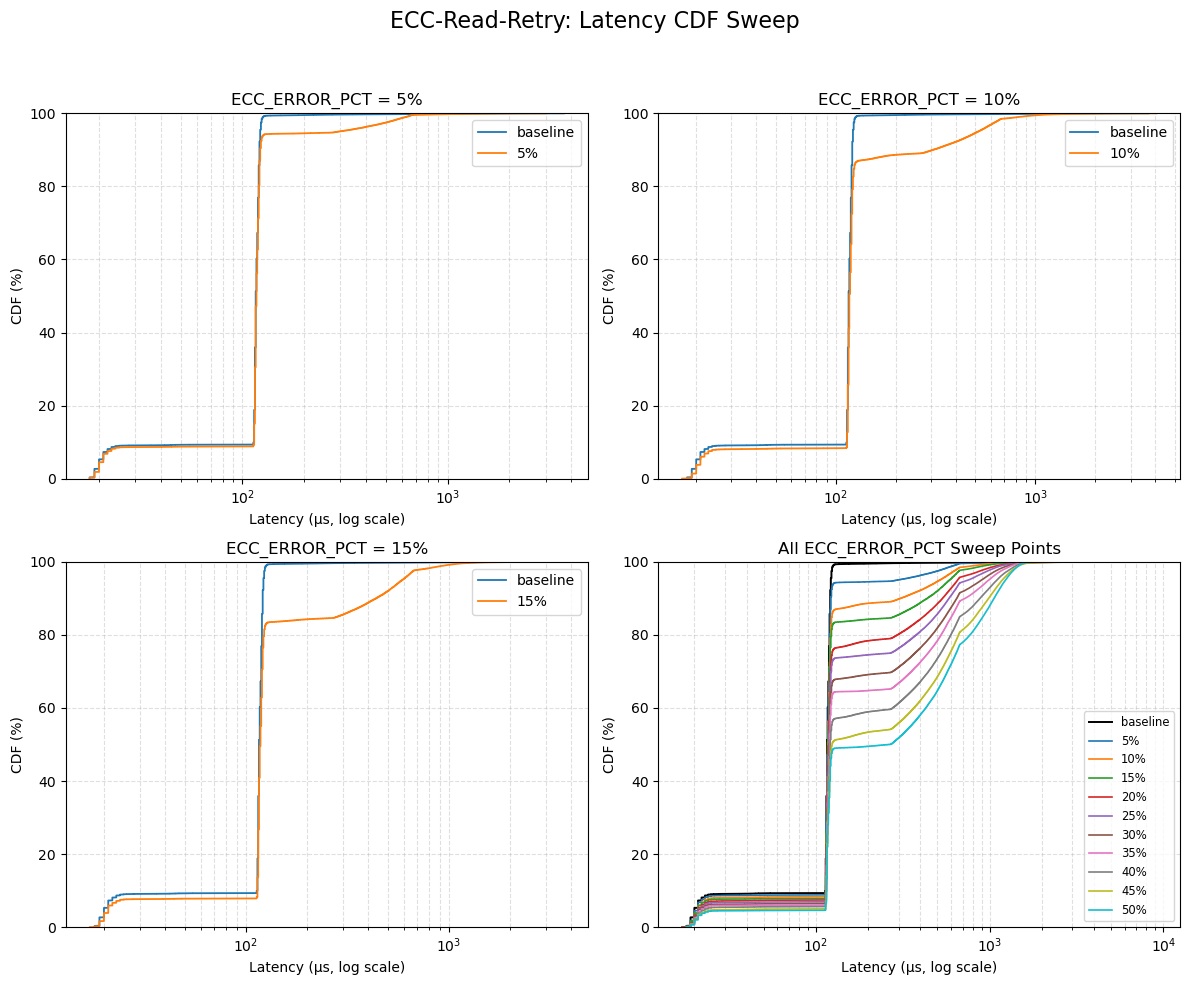

<Figure size 640x480 with 0 Axes>

In [39]:
import os, re
import numpy as np
import matplotlib.pyplot as plt

def load_latencies(path, cap=None):
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2:
                continue
            try:
                us = float(parts[1])
            except:
                continue
            if cap is None or us <= cap:
                lats.append(us)
    return np.array(lats)

# ── CONFIGURE PATHS & CONSTANTS ────────────────────────────────────────────
baseline_file       = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
sweep_dir           = r"C:\logs\sweep_logs\ecc_read_retry_sweep_ECC_ERROR_PCT"
latency_cap         = None   # e.g. 1e6 to filter extreme outliers

# these were held fixed during your ECC_ERROR_PCT sweep:
MAX_ECC_RETRIES     = 3      # <- your chosen constant
MIN_ECC_DELAY_US    = 100    # <- e.g. 100 µs
MAX_ECC_DELAY_US    = 500    # <- e.g. 500 µs

# ── DISCOVER & SORT ECC_ERROR_PCT SWEEP POINTS ─────────────────────────────
pat = re.compile(r"_ECC_ERROR_PCT(\d+)\.log$")
points = []
for fn in os.listdir(sweep_dir):
    m = pat.search(fn)
    if m:
        pct = int(m.group(1))
        points.append((pct, fn))
points.sort(key=lambda x: x[0])
values, files = zip(*points)

# ── PRINT CONSTANTS & SWEEP VALUES ─────────────────────────────────────────
print("#### ECC-Read-Retry Sweep Constants")
print("| Parameter             | Value |")
print("|:----------------------|:-----:|")
print(f"| MAX_ECC_RETRIES       |  {MAX_ECC_RETRIES}   |")
print(f"| MIN_ECC_DELAY_US (µs) |  {MIN_ECC_DELAY_US}   |")
print(f"| MAX_ECC_DELAY_US (µs) |  {MAX_ECC_DELAY_US}   |")
print()
print("#### Swept ECC_ERROR_PCT Values")
print("| ECC_ERROR_PCT (%) |")
print("|:-----------------:|")
for v in values:
    print(f"|       {v:>2}         |")

# ── LOAD & SORT BASELINE ────────────────────────────────────────────────────
base = load_latencies(baseline_file, latency_cap)
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# ── PLOT 2×2 GRID: first 3 points + combined ───────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

for i in range(min(3, len(values))):
    pct = values[i]
    path = os.path.join(sweep_dir, files[i])
    data = load_latencies(path, latency_cap)
    data.sort()
    cdf  = np.arange(1, len(data)+1) / len(data) * 100

    ax = axes[i]
    ax.plot(base,  base_cdf, label="baseline", lw=1.3)
    ax.plot(data,  cdf,       label=f"{pct}%", lw=1.3)
    ax.set_xscale("log")
    ax.set_ylim(0,100)
    ax.set_title(f"ECC_ERROR_PCT = {pct}%")
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_ylabel("CDF (%)")
    ax.grid(True, which="both", ls="--", alpha=0.4)
    ax.legend()

ax = axes[3]
ax.plot(base, base_cdf, lw=1.4, label="baseline", color="k")
for pct, fn in zip(values, files):
    data = load_latencies(os.path.join(sweep_dir, fn), latency_cap)
    data.sort()
    cdf  = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.2, label=f"{pct}%")
ax.set_xscale("log")
ax.set_ylim(0,100)
ax.set_title("All ECC_ERROR_PCT Sweep Points")
ax.set_xlabel("Latency (µs, log scale)")
ax.set_ylabel("CDF (%)")
ax.grid(True, which="both", ls="--", alpha=0.4)
ax.legend(fontsize="small", loc="lower right")

plt.suptitle("ECC-Read-Retry: Latency CDF Sweep", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
plt.savefig("ecc_read_retry_cdf_sweep.png", dpi=300)


| Parameter               | Value                              |
|:------------------------|:-----------------------------------|
| ECC_ERROR_PCT (%)       | 10                                 |
| MIN_ECC_DELAY_US (µs)   | 100                                 |
| MAX_ECC_DELAY_US (µs)   | 500                                 |
| MAX_ECC_RETRIES sweep   | 1, 2, 3, 4, 5                       |



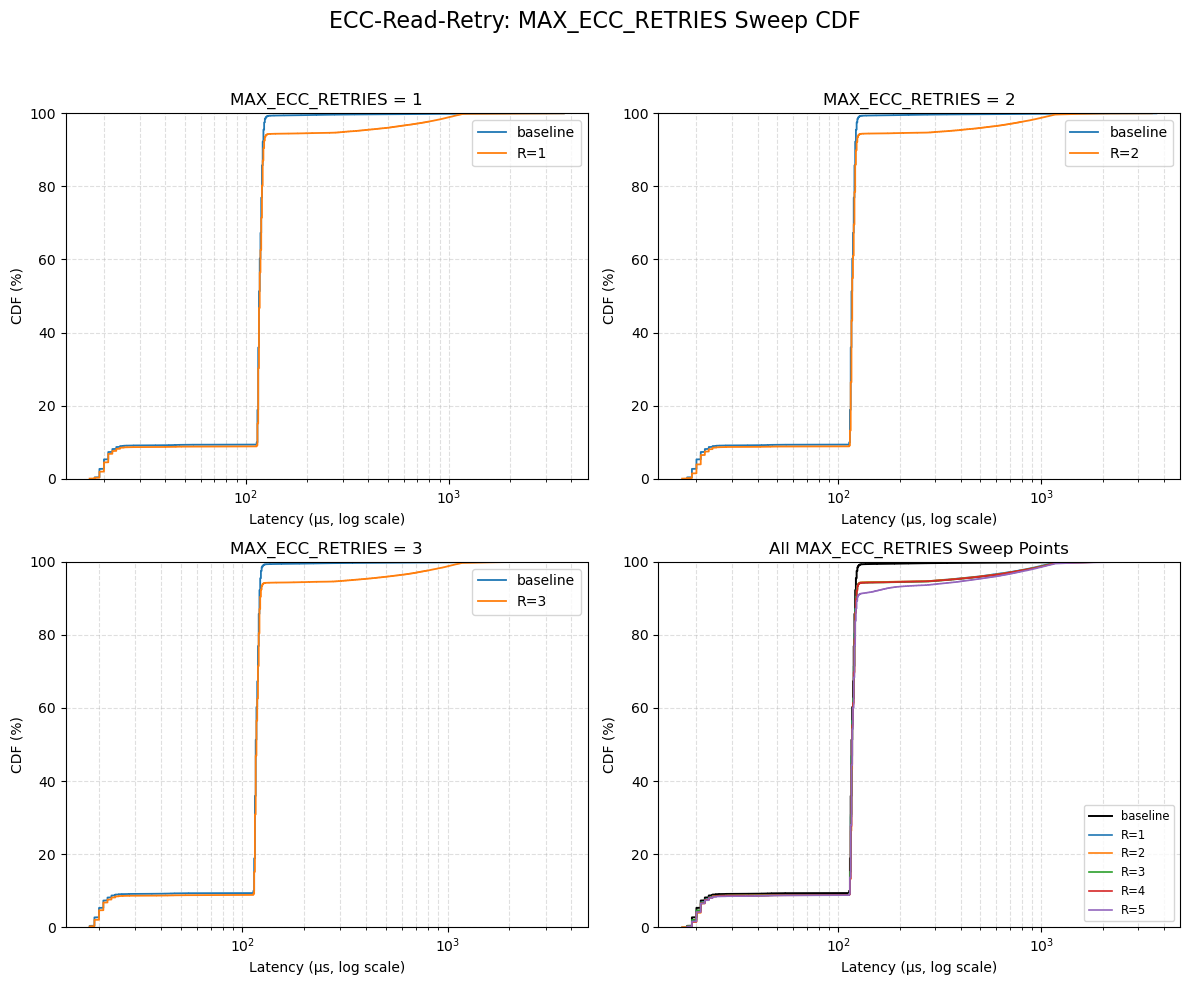

<Figure size 640x480 with 0 Axes>

In [41]:
import os, re
import numpy as np
import matplotlib.pyplot as plt

def load_latencies(path, cap=None):
    """Read 2nd CSV field (latency) from each line in `path`."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2:
                continue
            try:
                us = float(parts[1])
            except:
                continue
            if cap is None or us <= cap:
                lats.append(us)
    return np.array(lats)

# ── CONFIG ────────────────────────────────────────────────────────────────
baseline_file = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
sweep_dir     = r"C:\logs\sweep_logs\ecc_read_retry_sweep_MAX_ECC_RETRIES"
latency_cap   = None   # e.g. 1e6 to trim extreme outliers

# constants held fixed
ECC_ERROR_PCT   = 10
MIN_ECC_DELAY_US= 100
MAX_ECC_DELAY_US= 500

# discover & sort sweep points
pat = re.compile(r"_MAX_ECC_RETRIES(\d+)\.log$")
points = []
for fn in os.listdir(sweep_dir):
    m = pat.search(fn)
    if m:
        r = int(m.group(1))
        points.append((r, fn))
points.sort(key=lambda x: x[0])
retries, files = zip(*points)

# ── PRINT TABLE ───────────────────────────────────────────────────────────
print("| Parameter               | Value                              |")
print("|:------------------------|:-----------------------------------|")
print(f"| ECC_ERROR_PCT (%)       | {ECC_ERROR_PCT}                                 |")
print(f"| MIN_ECC_DELAY_US (µs)   | {MIN_ECC_DELAY_US}                                 |")
print(f"| MAX_ECC_DELAY_US (µs)   | {MAX_ECC_DELAY_US}                                 |")
print(f"| MAX_ECC_RETRIES sweep   | {', '.join(str(r) for r in retries)}                       |")
print()

# ── LOAD & SORT BASELINE ───────────────────────────────────────────────────
base = load_latencies(baseline_file, latency_cap)
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# ── PLOT 2×2 GRID ───────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

for i in range(min(3, len(retries))):
    r    = retries[i]
    path = os.path.join(sweep_dir, files[i])
    data = load_latencies(path, latency_cap)
    data.sort()
    cdf  = np.arange(1, len(data)+1) / len(data) * 100

    ax = axes[i]
    ax.plot(base,  base_cdf, label="baseline", lw=1.3)
    ax.plot(data,  cdf,       label=f"R={r}",    lw=1.3)
    ax.set_xscale("log")
    ax.set_ylim(0,100)
    ax.set_title(f"MAX_ECC_RETRIES = {r}")
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_ylabel("CDF (%)")
    ax.grid(True, which="both", ls="--", alpha=0.4)
    ax.legend()

# overlay all
ax = axes[3]
ax.plot(base, base_cdf, lw=1.4, label="baseline", color="k")
for r, fn in zip(retries, files):
    data = load_latencies(os.path.join(sweep_dir, fn), latency_cap)
    data.sort()
    cdf  = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.2, label=f"R={r}")
ax.set_xscale("log")
ax.set_ylim(0,100)
ax.set_title("All MAX_ECC_RETRIES Sweep Points")
ax.set_xlabel("Latency (µs, log scale)")
ax.set_ylabel("CDF (%)")
ax.grid(True, which="both", ls="--", alpha=0.4)
ax.legend(fontsize="small", loc="lower right")

plt.suptitle("ECC-Read-Retry: MAX_ECC_RETRIES Sweep CDF", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
plt.savefig("ecc_read_retry_retries_sweep.png", dpi=300)


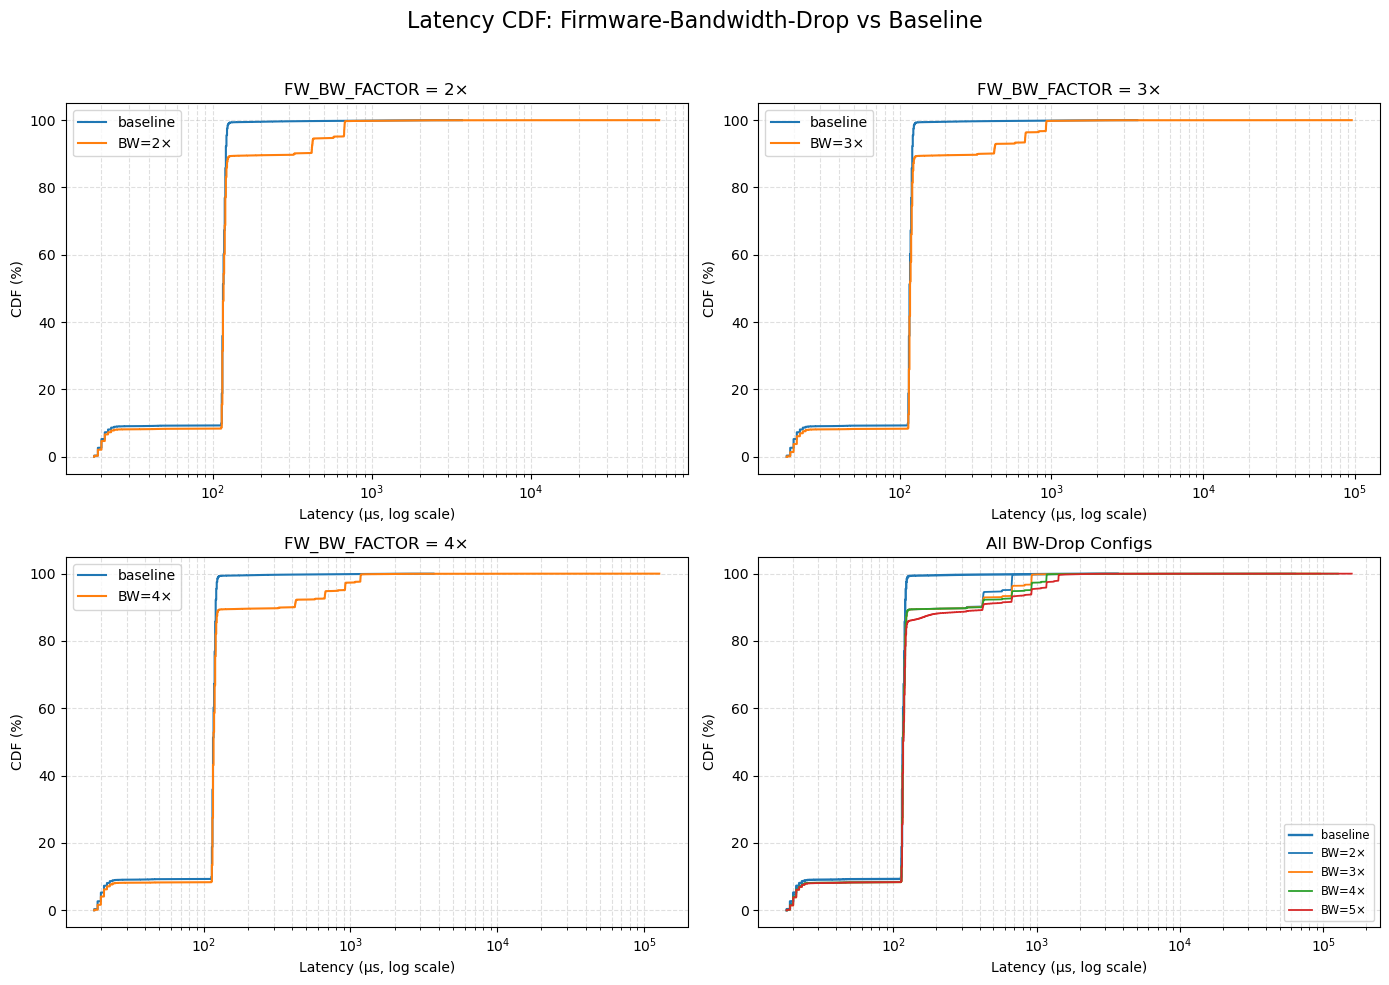

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_latencies(path, cap=None):
    """Read the 2nd comma-delimited field (latency) from each CSV line."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                try:
                    l = float(parts[1])
                    if cap is None or l <= cap:
                        lats.append(l)
                except:
                    pass
    return np.array(lats)

# ── CONFIG ────────────────────────────────────────────────────────────────
log_dir       = r"C:\logs\sweep_logs\firmware_bandwidth_drop_sweep_FW_BW_FACTOR"
baseline_file = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
latency_cap   = None   # e.g. 1e6 to clip extreme outliers
# ────────────────────────────────────────────────────────────────────────────

# 1) discover all the FW_BW_FACTOR files in the sweep directory
all_files = sorted(os.listdir(log_dir))
configs = []
for fname in all_files:
    if fname.startswith("trace_p100_sample100k_firmware_bandwidth_drop_FW_BW_FACTOR") and fname.endswith(".log"):
        # extract the numeric factor
        suffix = fname.split("FW_BW_FACTOR",1)[1]
        try:
            f = int(suffix.split(".log")[0])
        except:
            continue
        configs.append((f, fname, f"BW={f}×"))

# sort by factor
configs.sort(key=lambda x: x[0])

if not configs:
    raise RuntimeError(f"No sweep logs found in {log_dir}")

# 2) load & sort baseline
base = load_latencies(baseline_file, latency_cap)
if len(base)==0:
    raise RuntimeError(f"Baseline file appears empty: {baseline_file}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 3) prepare 2×2 plot grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# 4) plot each factor in its own subplot (up to 3)
for idx, (f, fname, label) in enumerate(configs[:3]):
    ax = axes[idx]
    path = os.path.join(log_dir, fname)
    data = load_latencies(path, latency_cap)
    if len(data)==0:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_title(f"FW_BW_FACTOR={f}×")
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100

    ax.plot(base,  base_cdf, lw=1.5, label="baseline", color='tab:blue')
    ax.plot(data,  cdf,      lw=1.5, label=label,   color='tab:orange')
    ax.set_xscale('log')
    ax.set_ylabel("CDF (%)")
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_title(f"FW_BW_FACTOR = {f}×")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 5) fourth panel: overlay of all sweep points
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for f, fname, label in configs:
    data = load_latencies(os.path.join(log_dir, fname), latency_cap)
    if len(data)==0: 
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_ylabel("CDF (%)")
ax.set_xlabel("Latency (µs, log scale)")
ax.set_title("All BW-Drop Configs")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: Firmware-Bandwidth-Drop vs Baseline", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


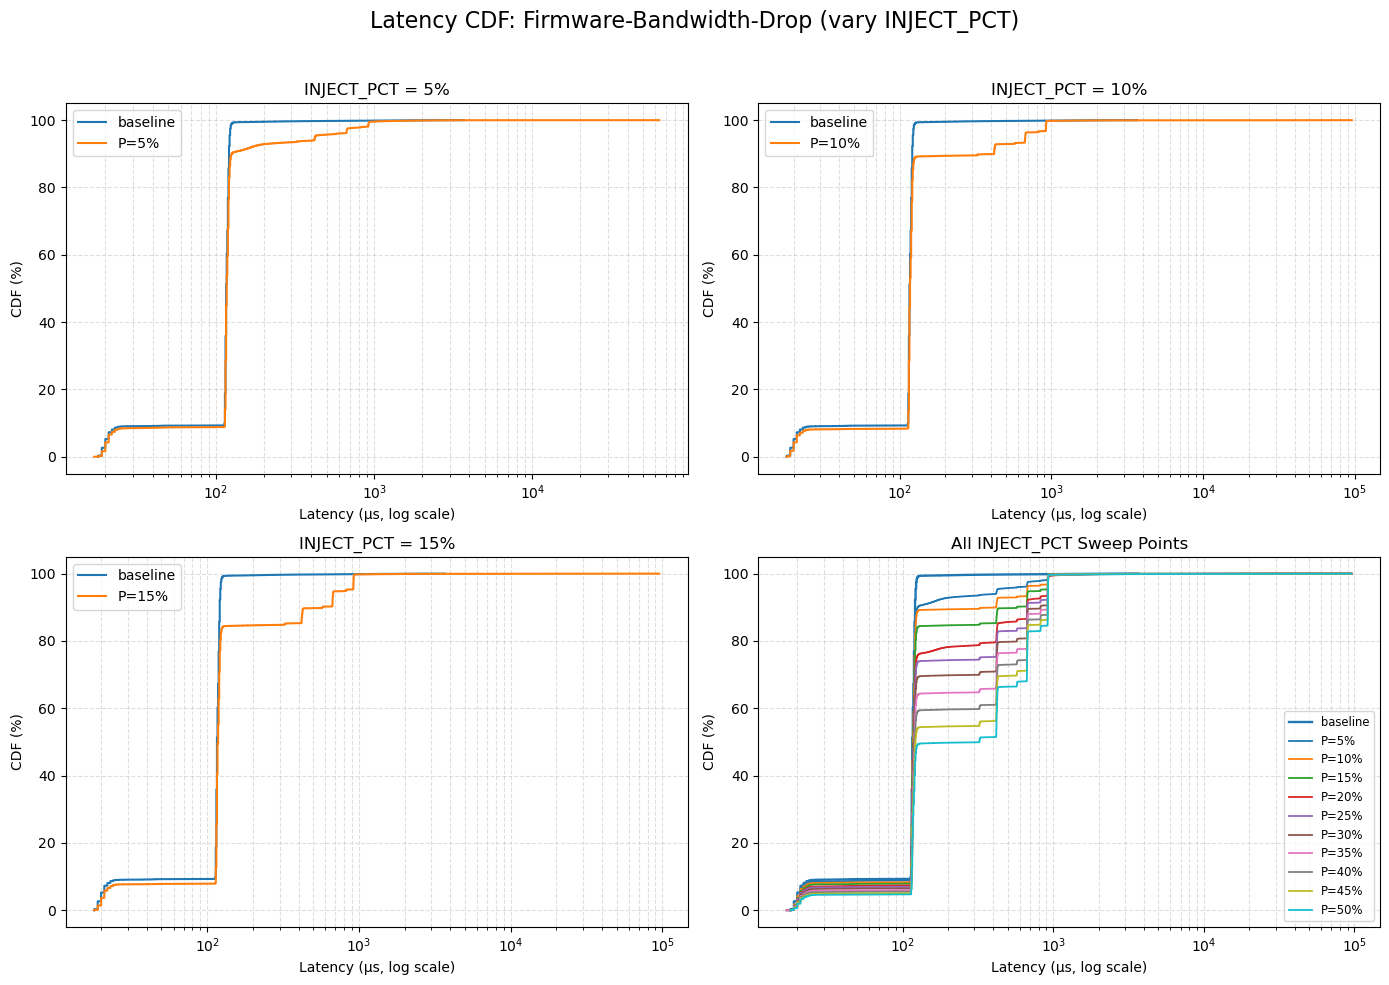

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_latencies(path, cap=None):
    """Read the 2nd comma-delimited field (latency) from each CSV line."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                try:
                    l = float(parts[1])
                    if cap is None or l <= cap:
                        lats.append(l)
                except:
                    pass
    return np.array(lats)

# ── CONFIG ────────────────────────────────────────────────────────────────
log_dir       = r"C:\logs\sweep_logs\firmware_bandwidth_drop_sweep_INJECT_PCT"
baseline_file = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
latency_cap   = None   # or e.g. 1e6 to clip outliers
# ────────────────────────────────────────────────────────────────────────────

# 1) auto-discover all the INJECT_PCT logs
all_files = sorted(os.listdir(log_dir))
configs = []
for fname in all_files:
    if fname.startswith("trace_p100_sample100k_firmware_bandwidth_drop_INJECT_PCT") and fname.endswith(".log"):
        suffix = fname.split("INJECT_PCT",1)[1]
        try:
            pct = int(suffix.split(".log")[0])
        except:
            continue
        configs.append((pct, fname, f"P={pct}%"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No sweep logs found in {log_dir}")

# 2) load & sort baseline
base = load_latencies(baseline_file, latency_cap)
if len(base)==0:
    raise RuntimeError(f"Baseline file appears empty: {baseline_file}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 3) prepare 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# 4) plot first three sweep points individually
for idx, (pct, fname, label) in enumerate(configs[:3]):
    ax = axes[idx]
    path = os.path.join(log_dir, fname)
    data = load_latencies(path, latency_cap)
    if len(data)==0:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_title(f"INJECT_PCT={pct}%")
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100

    ax.plot(base,  base_cdf, lw=1.5, label="baseline", color='tab:blue')
    ax.plot(data,  cdf,      lw=1.5, label=label,   color='tab:orange')
    ax.set_xscale('log')
    ax.set_ylabel("CDF (%)")
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_title(f"INJECT_PCT = {pct}%")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 5) overlay all
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for pct, fname, label in configs:
    data = load_latencies(os.path.join(log_dir, fname), latency_cap)
    if len(data)==0: 
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_ylabel("CDF (%)")
ax.set_xlabel("Latency (µs, log scale)")
ax.set_title("All INJECT_PCT Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: Firmware-Bandwidth-Drop (vary INJECT_PCT)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### FW-Bug-Random Sweep Constants
| Parameter              | Value |
|:-----------------------|:-----:|
| INJECT_PCT (%)         |  5   |
| RANDOM_MAX_RETRIES     |  2   |

#### Swept Max_Delay Values
| Max_Delay (ms) |
|:--------------:|
|      10       |
|      20       |
|      30       |
|      40       |
|      50       |
|      60       |
|      70       |
|      80       |
|      90       |
|      100       |




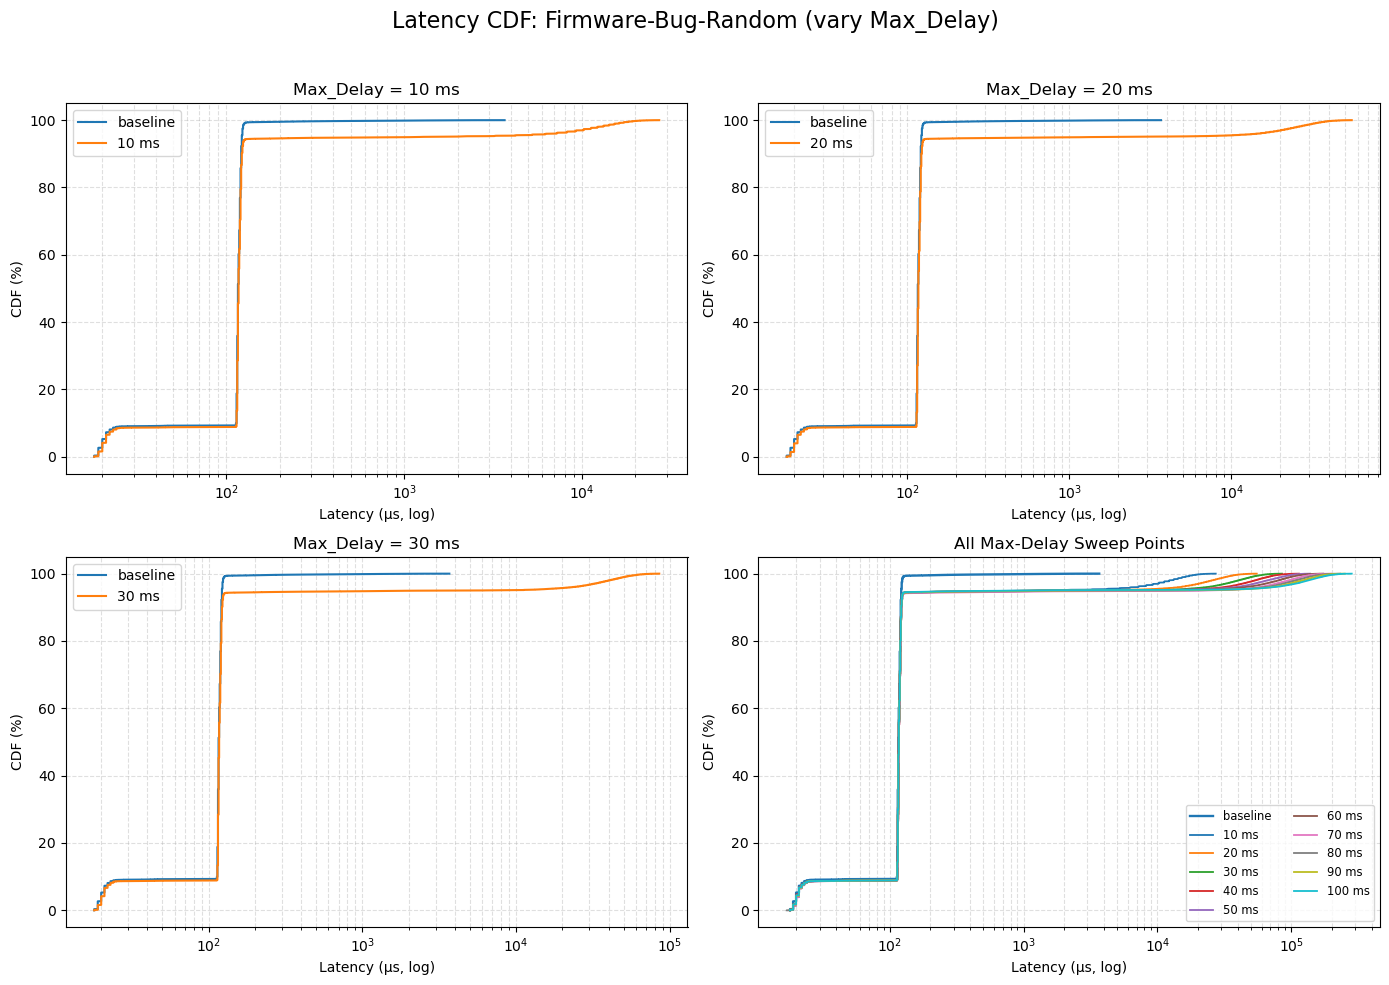

In [29]:
#!/usr/bin/env python3
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG — set these to where your files really live ─────────────────────
SWEEP_DIR     = r"C:\logs\sweep_logs\firmware_bug_random_sweep_RANDOM_MAX_DELAY_MS"
BASELINE_FILE = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP   = None   # e.g. 1e6 to clip extreme outliers
# These were kept constant during the sweep:
CONST_INJECT_PCT         = 5     # %
CONST_RANDOM_MAX_RETRIES = 2     # retries per error
# ─────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                try:
                    l = float(parts[1])
                    if cap is None or l <= cap:
                        lats.append(l)
                except:
                    pass
    return np.array(lats)

# 1) discover all sweep logs and extract their numeric “delay_ms” value
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.match(r".*RANDOM_MAX_DELAY_MS(\d+)\.log$", fn)
    if m:
        ms = int(m.group(1))
        configs.append((ms, fn, f"{ms} ms"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No sweep logs found in {SWEEP_DIR}")

# 2) print out our two markdown tables
print("#### FW-Bug-Random Sweep Constants")
print("| Parameter              | Value |")
print("|:-----------------------|:-----:|")
print(f"| INJECT_PCT (%)         |  {CONST_INJECT_PCT}   |")
print(f"| RANDOM_MAX_RETRIES     |  {CONST_RANDOM_MAX_RETRIES}   |")
print()
print("#### Swept Max_Delay Values")
print("| Max_Delay (ms) |")
print("|:--------------:|")
for ms, _, _ in configs:
    print(f"|      {ms}       |")
print("\n")

# 3) load & sort the baseline latencies
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base)==0:
    raise RuntimeError(f"Baseline file is empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) make a 2×2 grid and plot
fig, axes = plt.subplots(2,2,figsize=(14,10))
axes = axes.flatten()

# first three run in their own panels
for i,(ms,fn,label) in enumerate(configs[:3]):
    ax = axes[i]
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1,len(data)+1)/len(data)*100
        ax.plot(base, base_cdf, label="baseline", color='tab:blue', lw=1.5)
        ax.plot(data, cdf,       label=label,      color='tab:orange', lw=1.5)
    else:
        ax.text(0.5,0.5,"no data",ha='center',va='center')
    ax.set_xscale('log')
    ax.set_ylabel("CDF (%)")
    ax.set_xlabel("Latency (µs, log)")
    ax.set_title(f"Max_Delay = {ms} ms")
    ax.grid(True,which='both',ls='--',alpha=0.4)
    ax.legend()

# bottom-right: overlay all
ax = axes[3]
ax.plot(base, base_cdf, label="baseline", color='tab:blue', lw=1.7)
for ms,fn,label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data): continue
    data.sort()
    cdf = np.arange(1,len(data)+1)/len(data)*100
    ax.plot(data, cdf, label=label, lw=1.3)
ax.set_xscale('log')
ax.set_ylabel("CDF (%)")
ax.set_xlabel("Latency (µs, log)")
ax.set_title("All Max-Delay Sweep Points")
ax.grid(True,which='both',ls='--',alpha=0.4)
ax.legend(loc='lower right',fontsize='small',ncol=2)

plt.suptitle("Latency CDF: Firmware-Bug-Random (vary Max_Delay)",fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### FW-Bug-Random Sweep Constants
| Parameter                 | Value |
|:--------------------------|:-----:|
| INJECT_PCT (%)            |  10   |
| RANDOM_MAX_DELAY_MS (ms)  |  20   |

#### Swept RANDOM_MAX_RETRIES
| RANDOM_MAX_RETRIES |
|:------------------:|
|         1          |
|         2          |
|         3          |
|         4          |
|         5          |




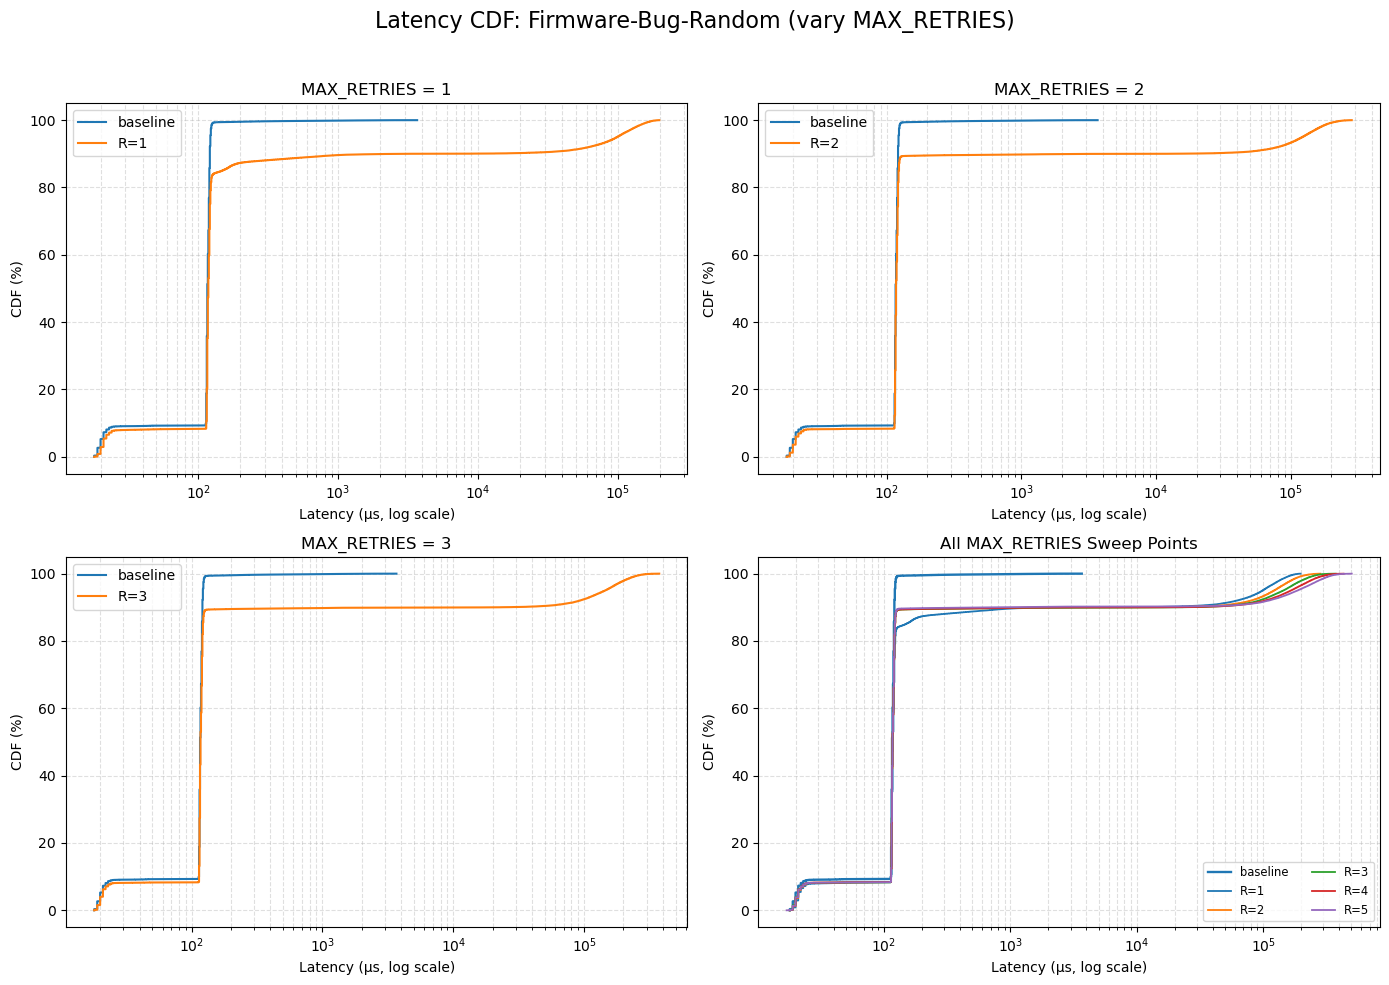

In [47]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG — EDIT THESE TWO PATHS ONLY ──────────────────────────────────────
SWEEP_DIR     = r"C:\logs\sweep_logs\firmware_bug_random_sweep_RANDOM_MAX_RETRIES"
BASELINE_FILE = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
# ────────────────────────────────────────────────────────────────────────────

# If you clipped outliers, set LATENCY_CAP to e.g. 1e6; else None
LATENCY_CAP = None  

# These were held constant during your sweep — adjust to match how you ran it:
CONST_INJECT_PCT         = 10    # e.g. you ran with INJECT_PCT=5
CONST_RANDOM_MAX_DELAY_MS = 20  # e.g. you ran with RANDOM_MAX_DELAY_MS=20
# ────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                try:
                    v = float(parts[1])
                    if cap is None or v <= cap:
                        lats.append(v)
                except:
                    pass
    return np.array(lats)

# 1) discover all your sweep‐point logs and pull out the retry count
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    if fn.endswith(".log") and "RANDOM_MAX_RETRIES" in fn:
        m = re.search(r"RANDOM_MAX_RETRIES(\d+)\.log$", fn)
        if m:
            r = int(m.group(1))
            configs.append((r, fn, f"R={r}"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No sweep logs in {SWEEP_DIR}")

# 2) print your two markdown tables
print("#### FW-Bug-Random Sweep Constants")
print("| Parameter                 | Value |")
print("|:--------------------------|:-----:|")
print(f"| INJECT_PCT (%)            |  {CONST_INJECT_PCT}   |")
print(f"| RANDOM_MAX_DELAY_MS (ms)  |  {CONST_RANDOM_MAX_DELAY_MS}   |")
print()
print("#### Swept RANDOM_MAX_RETRIES")
print("| RANDOM_MAX_RETRIES |")
print("|:------------------:|")
for r,_,_ in configs:
    print(f"|         {r}          |")
print("\n")

# 3) load & sort the baseline latencies
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError(f"Baseline empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) make a 2×2 grid of CDFs
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()

# panels 0–2: first 3 retry‐counts
for i, (r, fn, label) in enumerate(configs[:3]):
    ax = axes[i]
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base, base_cdf, label="baseline", color='tab:blue', lw=1.5)
        ax.plot(data, cdf,       label=label,      color='tab:orange', lw=1.5)
    else:
        ax.text(0.5, 0.5, "no data", ha='center', va='center')
    ax.set_xscale('log')
    ax.set_ylabel("CDF (%)")
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_title(f"MAX_RETRIES = {r}")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# panel 3: overlay all sweep‐points
ax = axes[3]
ax.plot(base, base_cdf, label="baseline", color='tab:blue', lw=1.7)
for r, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data): 
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, label=label, lw=1.3)
ax.set_xscale('log')
ax.set_ylabel("CDF (%)")
ax.set_xlabel("Latency (µs, log scale)")
ax.set_title("All MAX_RETRIES Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small', ncol=2)

plt.suptitle("Latency CDF: Firmware-Bug-Random (vary MAX_RETRIES)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### Firmware-Throttle Sweep Constants
| Parameter               | Value |
|:------------------------|:-----:|
| INJECT_PCT (%)          |   10   |
| THROTTLE_UNIT_US (µs)   |   250   |
| REBOOT_CHANCE_PCT (%)   |    1    |
| MAX_REBOOT_HANG_S (s)   |    1    |

#### Swept MAX_THROTTLE Values
| MAX_THROTTLE |
|:------------:|
|      1       |
|      2       |
|      3       |
|      4       |



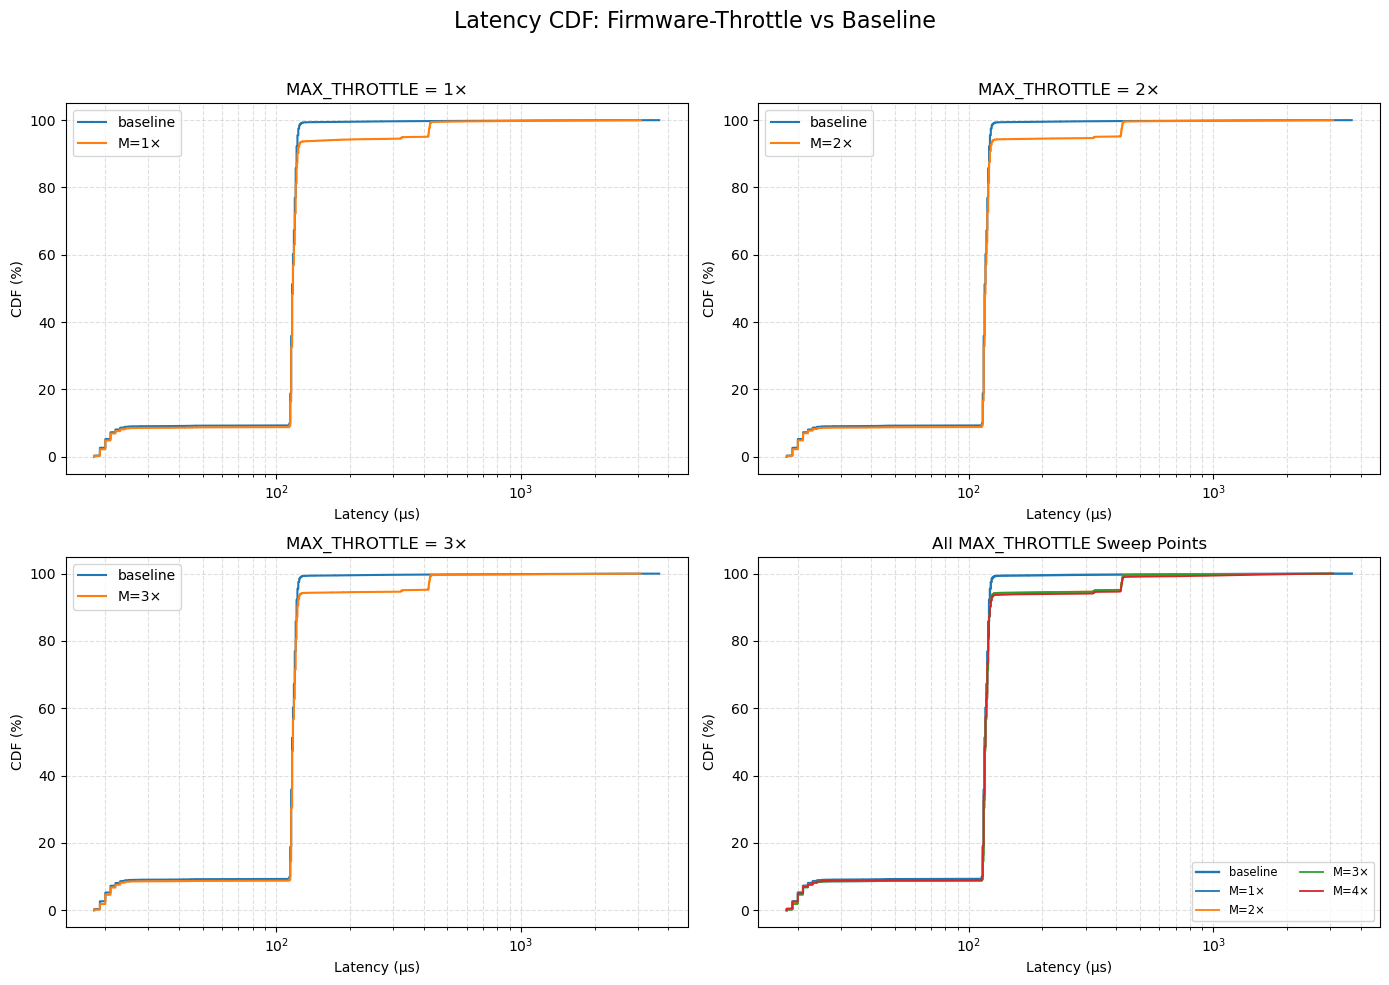

In [51]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
SWEEP_DIR     = r"C:\logs\sweep_logs\firmware_throttle_sweep_MAX_THROTTLE"
BASELINE_FILE = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP   = None   # or e.g. 1e6 to clip extremes
# ────────────────────────────────────────────────────────────────────────────

# Constants held fixed during the sweep:
CONST_INJECT_PCT        = 10    # %
CONST_THROTTLE_UNIT_US  = 250   # µs per throttle step
CONST_REBOOT_CHANCE_PCT = 1     # %
CONST_MAX_REBOOT_HANG_S = 1     # s

def load_latencies(path, cap=None):
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.split(',')
            if len(parts) >= 2:
                try:
                    v = float(parts[1])
                except:
                    continue
                if cap is None or v <= cap:
                    lats.append(v)
    return np.array(lats)

# 1) Find all the MAX_THROTTLE logs
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.match(r".*_MAX_THROTTLE(\d+)\.log$", fn)
    if m:
        mul = int(m.group(1))
        configs.append((mul, fn, f"M={mul}×"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No MAX_THROTTLE logs in {SWEEP_DIR}")

# 2) Print the two Markdown tables
print("#### Firmware-Throttle Sweep Constants")
print("| Parameter               | Value |")
print("|:------------------------|:-----:|")
print(f"| INJECT_PCT (%)          |   {CONST_INJECT_PCT}   |")
print(f"| THROTTLE_UNIT_US (µs)   |   {CONST_THROTTLE_UNIT_US}   |")
print(f"| REBOOT_CHANCE_PCT (%)   |    {CONST_REBOOT_CHANCE_PCT}    |")
print(f"| MAX_REBOOT_HANG_S (s)   |    {CONST_MAX_REBOOT_HANG_S}    |")
print()
print("#### Swept MAX_THROTTLE Values")
print("| MAX_THROTTLE |")
print("|:------------:|")
for mul,_,_ in configs:
    print(f"|      {mul}       |")
print()

# 3) Load & CDF‐ify the baseline
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError("Baseline appears empty")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) Plot 2×2 grid of CDFs
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()

# individual panels for the first three throttle settings
for i, (mul, fn, label) in enumerate(configs[:3]):
    ax = axes[i]
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1,len(data)+1)/len(data)*100
        ax.plot(base, base_cdf, label="baseline", color='tab:blue', lw=1.5)
        ax.plot(data, cdf,       label=label,      color='tab:orange', lw=1.5)
    else:
        ax.text(0.5,0.5,"no data",ha='center',va='center')
    ax.set_xscale('log')
    ax.set_ylabel("CDF (%)")
    ax.set_xlabel("Latency (µs)")
    ax.set_title(f"MAX_THROTTLE = {mul}×")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# overlay all four + baseline
ax = axes[3]
ax.plot(base, base_cdf, label="baseline", color='tab:blue', lw=1.7)
for mul, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data): continue
    data.sort()
    cdf = np.arange(1,len(data)+1)/len(data)*100
    ax.plot(data, cdf, label=label, lw=1.3)
ax.set_xscale('log')
ax.set_ylabel("CDF (%)")
ax.set_xlabel("Latency (µs)")
ax.set_title("All MAX_THROTTLE Sweep Points")
ax.grid(True,which='both',ls='--',alpha=0.4)
ax.legend(loc='lower right',fontsize='small',ncol=2)

plt.suptitle("Latency CDF: Firmware-Throttle vs Baseline", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### Small‐range Firmware‐Throttle‐MUL Sweep Constants
| Parameter               | Value |
|:------------------------|:-----:|
| INJECT_PCT (%)          |  10   |
| THROTTLE_UNIT_US (µs)   |  250  |
| REBOOT_CHANCE_PCT (%)   |   1   |
| MAX_REBOOT_HANG_S (s)   |   1   |

#### Swept MAX_THROTTLE_MUL Values
| MAX_THROTTLE_MUL |
|:----------------:|
|       1        |
|       2        |
|       3        |
|       4        |
|       5        |



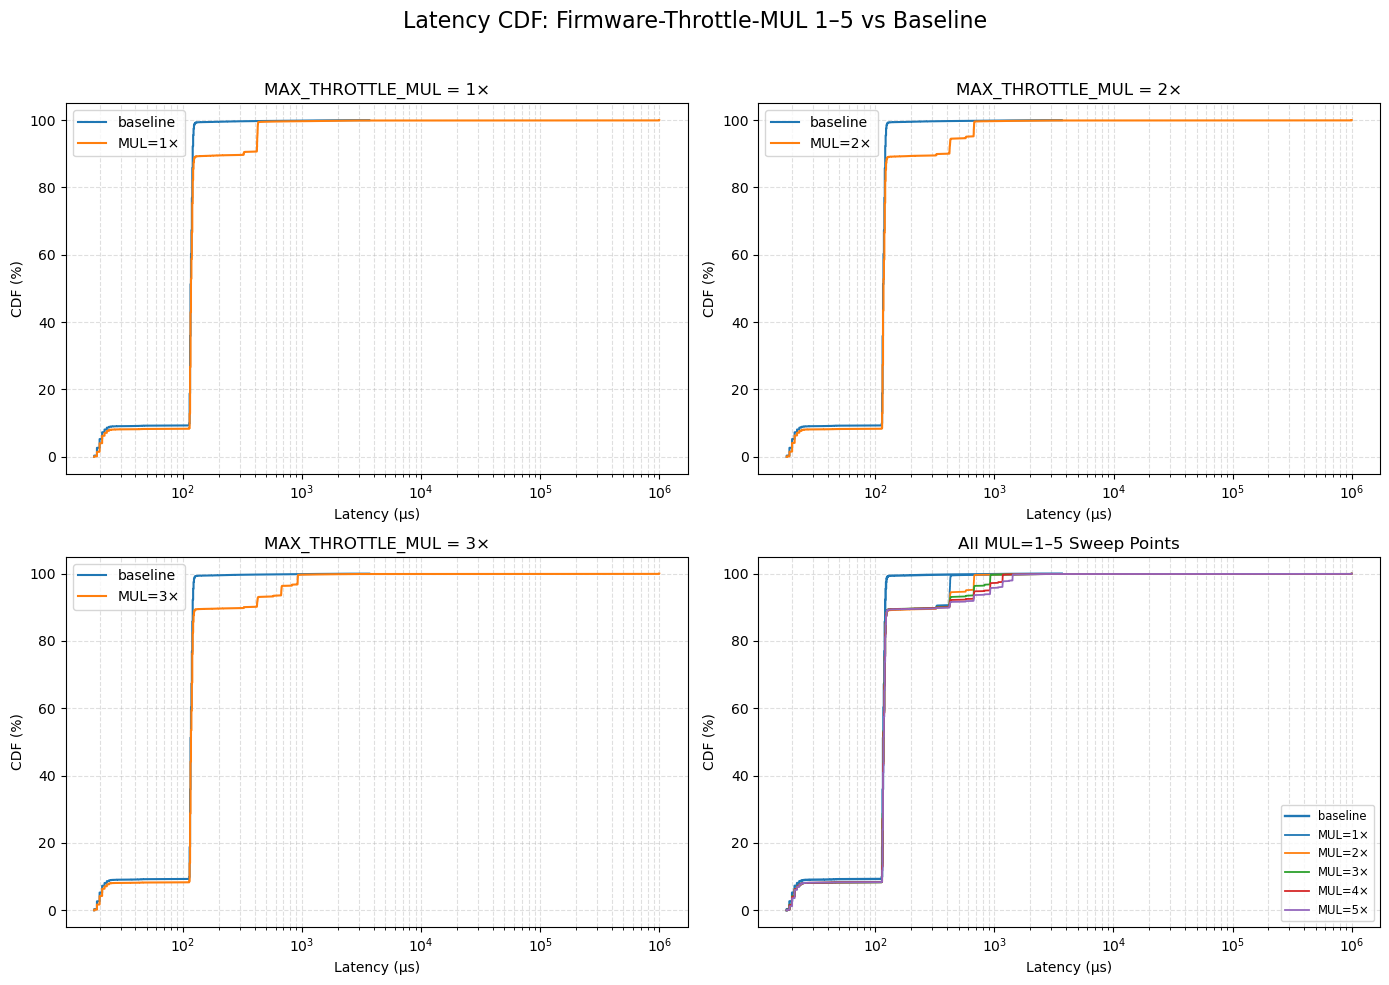

In [55]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ─────────────────────────────────────────────────
SWEEP_DIR     = r"C:\logs\sweep_logs\firmware_throttle_sweep_MAX_THROTTLE_MUL"
BASELINE_LOG  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP   = None   # clip outliers if you like
# constants you used in this small‐range run:
CONST_INJECT_PCT        = 10    # %
CONST_THROTTLE_UNIT_US  = 250   # µs per throttle step
CONST_REBOOT_CHANCE_PCT = 1     # %
CONST_MAX_REBOOT_HANG_S = 1     # s
# which MUs to include here:
SMALL_MULS = [1,2,3,4,5]
# ─────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    lats = []
    with open(path) as f:
        for line in f:
            parts = line.split(',')
            if len(parts) < 2: continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v<=cap:
                lats.append(v)
    return np.array(lats)

# 1) discover & filter
allf = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in allf:
    m = re.match(r".*_MAX_THROTTLE_MUL(\d+)\.log$", fn)
    if not m: continue
    mul = int(m.group(1))
    if mul in SMALL_MULS:
        configs.append((mul, fn, f"MUL={mul}×"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError("No small‐range logs found")

# 2) markdown tables
print("#### Small‐range Firmware‐Throttle‐MUL Sweep Constants")
print("| Parameter               | Value |")
print("|:------------------------|:-----:|")
print(f"| INJECT_PCT (%)          |  {CONST_INJECT_PCT}   |")
print(f"| THROTTLE_UNIT_US (µs)   |  {CONST_THROTTLE_UNIT_US}  |")
print(f"| REBOOT_CHANCE_PCT (%)   |   {CONST_REBOOT_CHANCE_PCT}   |")
print(f"| MAX_REBOOT_HANG_S (s)   |   {CONST_MAX_REBOOT_HANG_S}   |")
print()
print("#### Swept MAX_THROTTLE_MUL Values")
print("| MAX_THROTTLE_MUL |")
print("|:----------------:|")
for mul,_,_ in configs:
    print(f"|       {mul}        |")
print()

# 3) load baseline CDF
base = load_latencies(BASELINE_LOG, LATENCY_CAP)
base.sort()
base_cdf = np.arange(1,len(base)+1)/len(base)*100

# 4) plot
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()

# first three
for i, (mul,fn,label) in enumerate(configs[:3]):
    ax = axes[i]
    data = load_latencies(os.path.join(SWEEP_DIR,fn), LATENCY_CAP)
    if len(data)>0:
        data.sort()
        cdf = np.arange(1,len(data)+1)/len(data)*100
        ax.plot(base,base_cdf, label="baseline", color='tab:blue', lw=1.5)
        ax.plot(data,cdf,      label=label,      color='tab:orange', lw=1.5)
    else:
        ax.text(0.5,0.5,"no data",ha='center',va='center')
    ax.set_xscale('log')
    ax.set_ylabel("CDF (%)"); ax.set_xlabel("Latency (µs)")
    ax.set_title(f"MAX_THROTTLE_MUL = {mul}×")
    ax.grid(True,which='both',ls='--',alpha=0.4)
    ax.legend()

# overlay all
ax = axes[3]
ax.plot(base,base_cdf, label="baseline", color='tab:blue', lw=1.7)
for mul,fn,label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR,fn), LATENCY_CAP)
    if not len(data): continue
    data.sort()
    cdf = np.arange(1,len(data)+1)/len(data)*100
    ax.plot(data,cdf, label=label, lw=1.3)
ax.set_xscale('log')
ax.set_ylabel("CDF (%)"); ax.set_xlabel("Latency (µs)")
ax.set_title("All MUL=1–5 Sweep Points")
ax.grid(True,which='both',ls='--',alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: Firmware-Throttle-MUL 1–5 vs Baseline", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### Large‐range Firmware‐Throttle‐MUL Sweep Constants
| Parameter               |  Value  |
|:------------------------|:-------:|
| INJECT_PCT (%)          |   50   |
| THROTTLE_UNIT_US (µs)   |  1000  |
| REBOOT_CHANCE_PCT (%)   |   10   |
| MAX_REBOOT_HANG_S (s)   |   2   |

#### Swept MAX_THROTTLE_MUL Values
| MAX_THROTTLE_MUL |
|:----------------:|
|       10        |
|       15        |
|       20        |
|       25        |



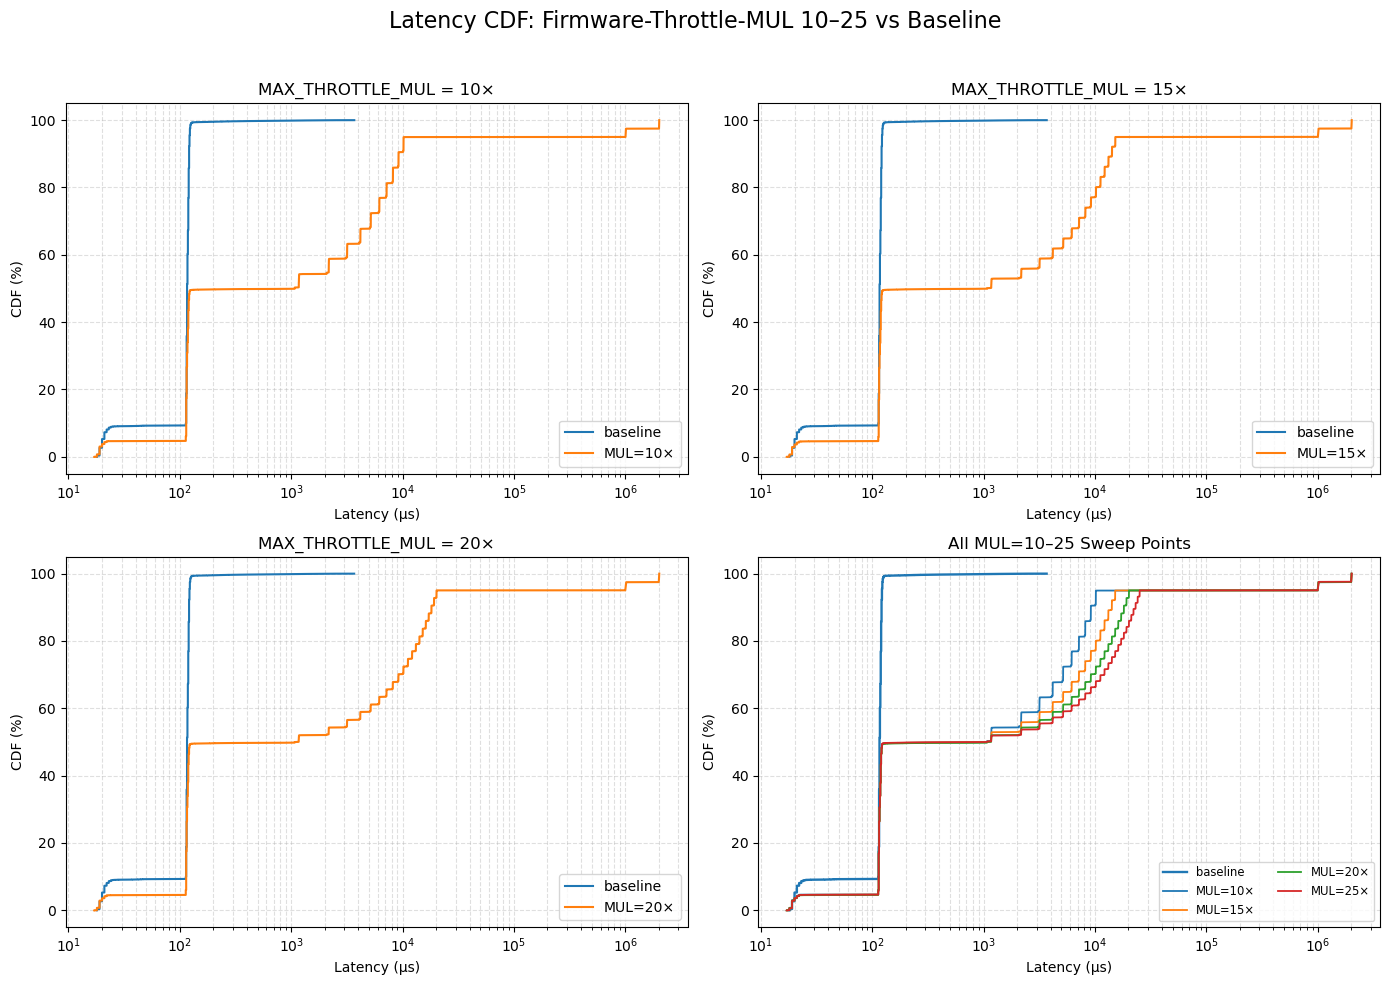

In [59]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ─────────────────────────────────────────────────
SWEEP_DIR     = r"C:\logs\sweep_logs\firmware_throttle_sweep_MAX_THROTTLE_MUL"
BASELINE_LOG  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP   = None
# constants you used in big‐impact run:
CONST_INJECT_PCT        = 50    # %
CONST_THROTTLE_UNIT_US  = 1000  # µs per step
CONST_REBOOT_CHANCE_PCT = 10    # %
CONST_MAX_REBOOT_HANG_S = 2     # s
# now start sweep at 10×, not 5×
LARGE_MULS = [10,15,20,25]
# ─────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    lats=[]
    with open(path) as f:
        for line in f:
            p=line.split(',')
            if len(p)<2: continue
            try: v=float(p[1])
            except: continue
            if cap is None or v<=cap:
                lats.append(v)
    return np.array(lats)

# 1) discover & filter
allf = sorted(os.listdir(SWEEP_DIR))
configs=[]
for fn in allf:
    m = re.match(r".*_MAX_THROTTLE_MUL(\d+)\.log$",fn)
    if not m: continue
    mul=int(m.group(1))
    if mul in LARGE_MULS:
        configs.append((mul,fn,f"MUL={mul}×"))
configs.sort(key=lambda x:x[0])
if not configs:
    raise RuntimeError("No large‐range logs found")

# 2) markdown tables
print("#### Large‐range Firmware‐Throttle‐MUL Sweep Constants")
print("| Parameter               |  Value  |")
print("|:------------------------|:-------:|")
print(f"| INJECT_PCT (%)          |   {CONST_INJECT_PCT}   |")
print(f"| THROTTLE_UNIT_US (µs)   |  {CONST_THROTTLE_UNIT_US}  |")
print(f"| REBOOT_CHANCE_PCT (%)   |   {CONST_REBOOT_CHANCE_PCT}   |")
print(f"| MAX_REBOOT_HANG_S (s)   |   {CONST_MAX_REBOOT_HANG_S}   |")
print()
print("#### Swept MAX_THROTTLE_MUL Values")
print("| MAX_THROTTLE_MUL |")
print("|:----------------:|")
for mul,_,_ in configs:
    print(f"|       {mul}        |")
print()

# 3) baseline
base = load_latencies(BASELINE_LOG, LATENCY_CAP)
base.sort()
base_cdf = np.arange(1,len(base)+1)/len(base)*100

# 4) plot
fig,axes=plt.subplots(2,2,figsize=(14,10))
axes=axes.flatten()

for i,(mul,fn,label) in enumerate(configs[:3]):
    ax=axes[i]
    d=load_latencies(os.path.join(SWEEP_DIR,fn),LATENCY_CAP)
    if len(d):
        d.sort(); cdf=np.arange(1,len(d)+1)/len(d)*100
        ax.plot(base,base_cdf,label="baseline",c='tab:blue',lw=1.5)
        ax.plot(d,cdf,label=label,      c='tab:orange',lw=1.5)
    else:
        ax.text(0.5,0.5,"no data",ha='center',va='center')
    ax.set_xscale('log'); ax.set_ylabel("CDF (%)"); ax.set_xlabel("Latency (µs)")
    ax.set_title(f"MAX_THROTTLE_MUL = {mul}×")
    ax.grid(True,which='both',ls='--',alpha=0.4)
    ax.legend()

ax=axes[3]
ax.plot(base,base_cdf,label="baseline",c='tab:blue',lw=1.7)
for mul,fn,label in configs:
    d=load_latencies(os.path.join(SWEEP_DIR,fn),LATENCY_CAP)
    if not len(d): continue
    d.sort(); cdf=np.arange(1,len(d)+1)/len(d)*100
    ax.plot(d,cdf,label=label,lw=1.3)
ax.set_xscale('log'); ax.set_ylabel("CDF (%)"); ax.set_xlabel("Latency (µs)")
ax.set_title("All MUL=10–25 Sweep Points")
ax.grid(True,which='both',ls='--',alpha=0.4)
ax.legend(loc='lower right',fontsize='small',ncol=2)

plt.suptitle("Latency CDF: Firmware-Throttle-MUL 10–25 vs Baseline",fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### FW-Throttle Sweep Constants
| Parameter                   | Value |
|:----------------------------|:-----:|
| INJECT_PCT (%)              |  10   |
| MAX_THROTTLE_MUL (×)        |  1   |
| REBOOT_CHANCE_PCT (%)       |  1   |
| MAX_REBOOT_HANG_S (s)       |  1   |

#### Swept THROTTLE_UNIT_US Values
| THROTTLE_UNIT_US (µs) |
|:----------------------:|
|          250           |
|          500           |
|          750           |
|          1000           |
|          1250           |
|          1500           |
|          1750           |
|          2000           |



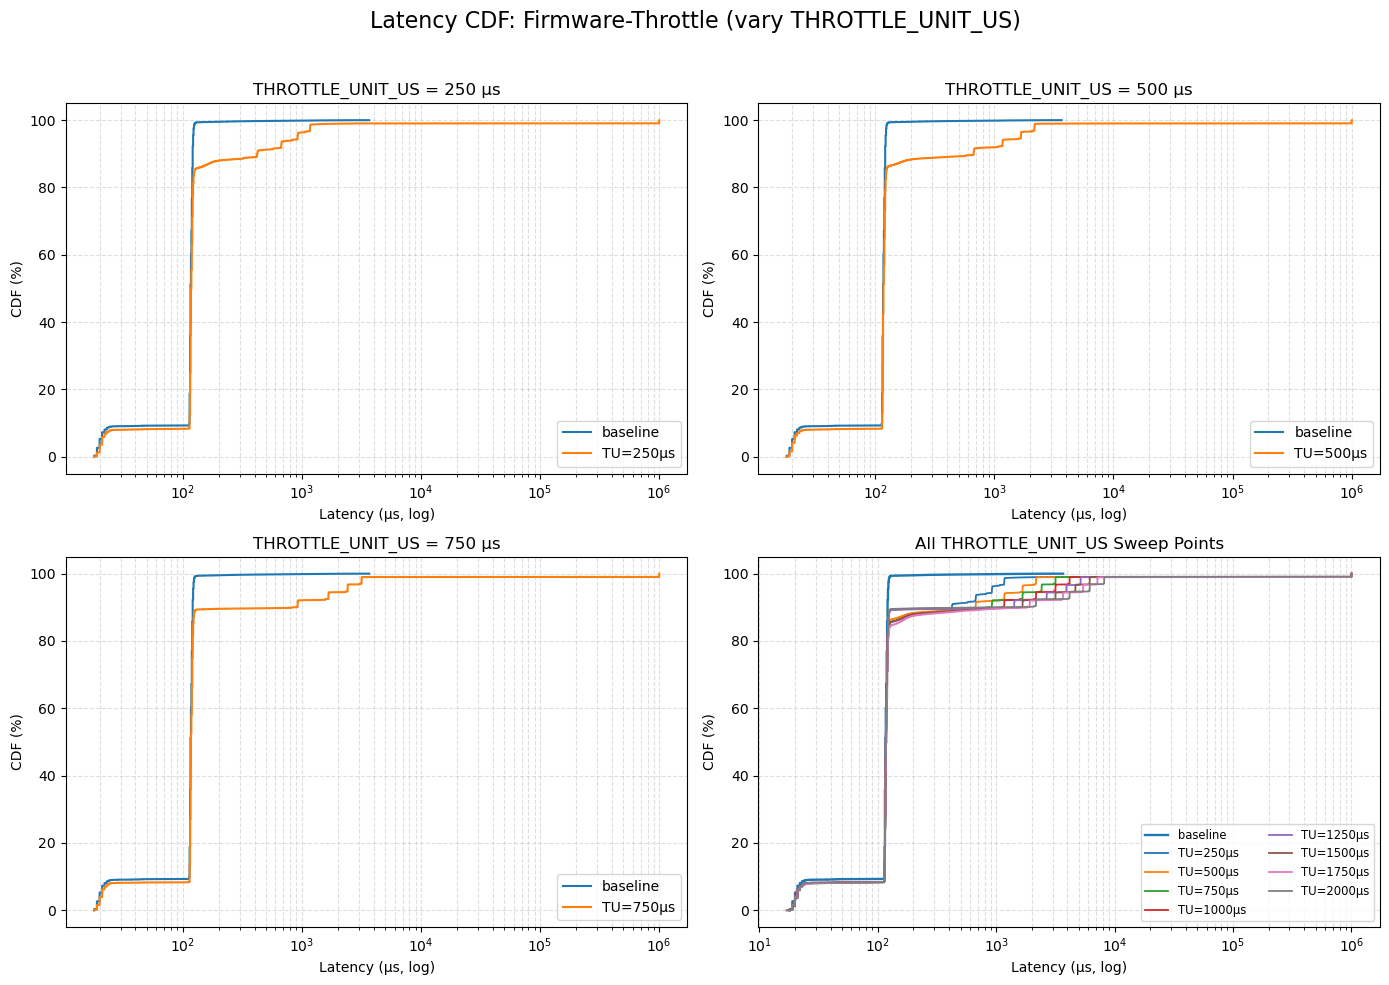

In [61]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
SWEEP_DIR      = r"C:\logs\sweep_logs\firmware_throttle_sweep_THROTTLE_UNIT_US"
BASELINE_FILE  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP    = None   # or e.g. 1e6 to clip extreme outliers

# Fill in the fixed parameters you used when generating these logs:
CONST_INJECT_PCT         = 10    # % I/Os throttled
CONST_MAX_THROTTLE_MUL   = 1     # max k (1×)
CONST_REBOOT_CHANCE_PCT  = 1     # % chance per I/O
CONST_MAX_REBOOT_HANG_S  = 1     # seconds
# ────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    l = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2: continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                l.append(v)
    return np.array(l)

# 1) discover sweep logs & extract their THROTTLE_UNIT_US
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"THROTTLE_UNIT_US(\d+)", fn)
    if not m or not fn.endswith(".log"):
        continue
    tu = int(m.group(1))
    configs.append((tu, fn, f"TU={tu}µs"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No THROTTLE_UNIT_US logs found in {SWEEP_DIR}")

# 2) print parameter tables
print("#### FW-Throttle Sweep Constants")
print("| Parameter                   | Value |")
print("|:----------------------------|:-----:|")
print(f"| INJECT_PCT (%)              |  {CONST_INJECT_PCT}   |")
print(f"| MAX_THROTTLE_MUL (×)        |  {CONST_MAX_THROTTLE_MUL}   |")
print(f"| REBOOT_CHANCE_PCT (%)       |  {CONST_REBOOT_CHANCE_PCT}   |")
print(f"| MAX_REBOOT_HANG_S (s)       |  {CONST_MAX_REBOOT_HANG_S}   |")
print()
print("#### Swept THROTTLE_UNIT_US Values")
print("| THROTTLE_UNIT_US (µs) |")
print("|:----------------------:|")
for tu,_,_ in configs:
    print(f"|          {tu}           |")
print()

# 3) load & sort baseline
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError(f"Baseline appears empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) plot 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# first three individual
for i, (tu, fn, label) in enumerate(configs[:3]):
    ax = axes[i]
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base, base_cdf, label="baseline", color='tab:blue', lw=1.5)
        ax.plot(data, cdf,       label=label,     color='tab:orange', lw=1.5)
    else:
        ax.text(0.5, 0.5, "no data", ha='center', va='center')
    ax.set_xscale('log')
    ax.set_xlabel("Latency (µs, log)")
    ax.set_ylabel("CDF (%)")
    ax.set_title(f"THROTTLE_UNIT_US = {tu} µs")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# overlay all
ax = axes[3]
ax.plot(base, base_cdf, label="baseline", color='tab:blue', lw=1.7)
for tu, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data): 
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, label=label, lw=1.3)
ax.set_xscale('log')
ax.set_xlabel("Latency (µs, log)")
ax.set_ylabel("CDF (%)")
ax.set_title("All THROTTLE_UNIT_US Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small', ncol=2)

plt.suptitle("Latency CDF: Firmware-Throttle (vary THROTTLE_UNIT_US)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### GC-Pause Sweep Constants
| Parameter             | Value |
|:----------------------|:-----:|
| GC_JITTER_MS (±ms)    |  100   |
| GC_PAUSE_MIN_MS (ms)  |  10   |
| GC_PAUSE_MAX_MS (ms)  |  30   |

#### Swept GC_INTERVAL_MS Values
| GC_INTERVAL_MS (ms) |
|:--------------------:|
|        500        |
|        1000        |
|        1500        |
|        2000        |



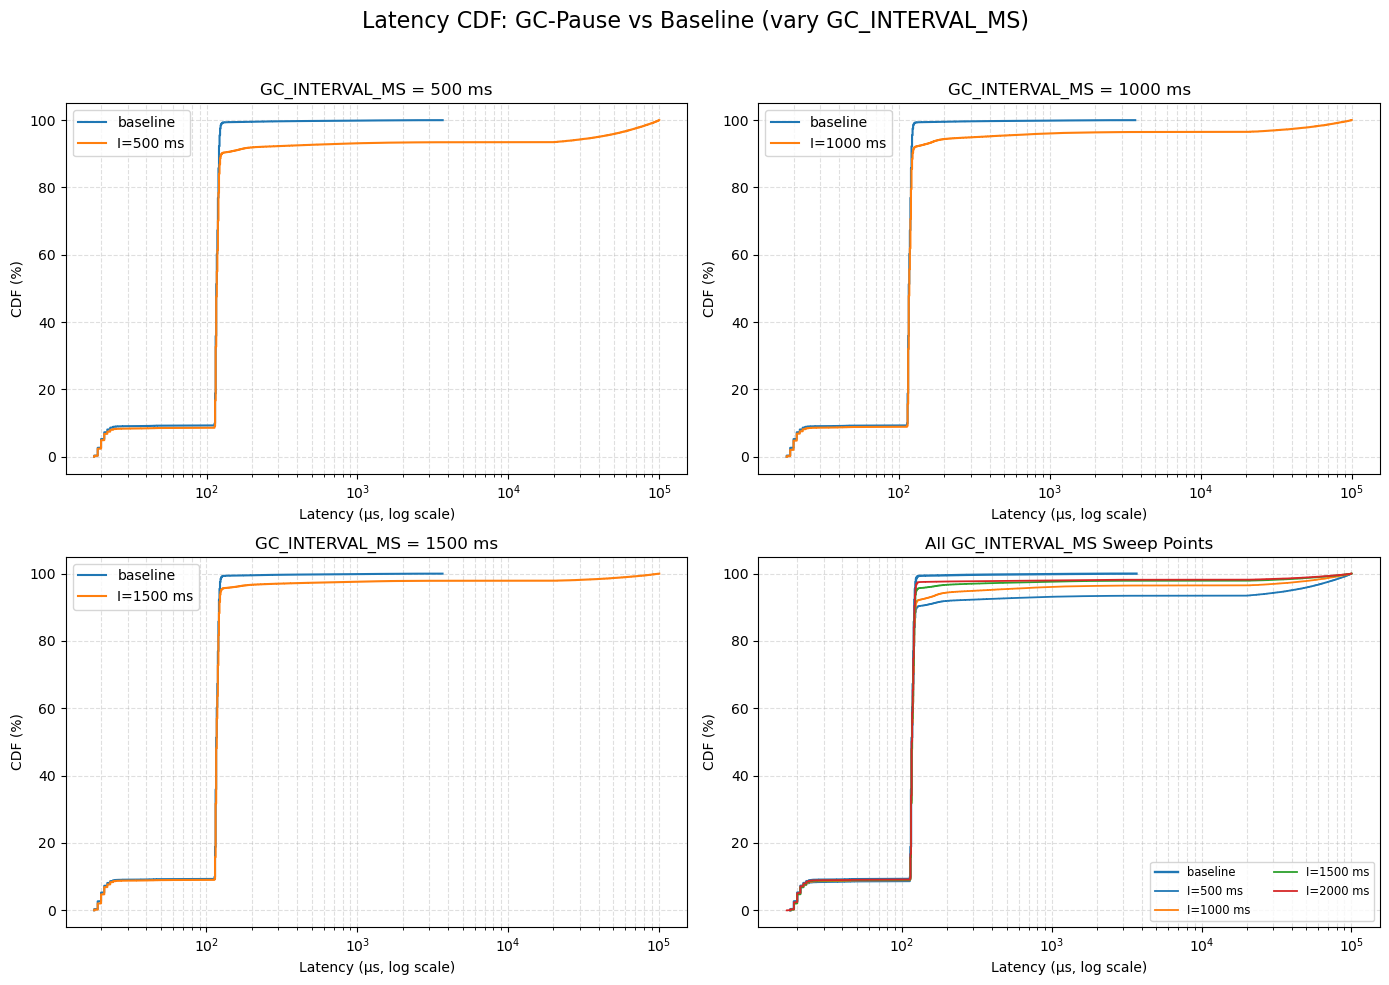

In [63]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
SWEEP_DIR      = r"C:\logs\sweep_logs\gc_pause_sweep_GC_INTERVAL_MS"
BASELINE_FILE  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP    = None   # e.g. 1e6 to clip extreme outliers

# These are the *fixed* GC-pause parameters you used when generating the logs:
CONST_GC_JITTER_MS   = 100   # ± jitter on the interval
CONST_GC_PAUSE_MIN_MS = 10   # minimum pause duration
CONST_GC_PAUSE_MAX_MS = 30   # maximum pause duration
# ────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    """Read the 2nd comma-delimited field (latency) from each CSV line."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2: 
                continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                lats.append(v)
    return np.array(lats)

# 1) Discover all sweep logs & extract the GC_INTERVAL_MS value from each filename
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"GC_INTERVAL_MS(\d+)\.log$", fn)
    if not m or not fn.endswith(".log"):
        continue
    interval = int(m.group(1))
    configs.append((interval, fn, f"I={interval} ms"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No GC-pause sweep logs found in {SWEEP_DIR}")

# 2) Print out the parameter tables
print("#### GC-Pause Sweep Constants")
print("| Parameter             | Value |")
print("|:----------------------|:-----:|")
print(f"| GC_JITTER_MS (±ms)    |  {CONST_GC_JITTER_MS}   |")
print(f"| GC_PAUSE_MIN_MS (ms)  |  {CONST_GC_PAUSE_MIN_MS}   |")
print(f"| GC_PAUSE_MAX_MS (ms)  |  {CONST_GC_PAUSE_MAX_MS}   |")
print()
print("#### Swept GC_INTERVAL_MS Values")
print("| GC_INTERVAL_MS (ms) |")
print("|:--------------------:|")
for interval, _, _ in configs:
    print(f"|        {interval}        |")
print()

# 3) Load & sort the baseline latencies
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError(f"Baseline appears empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) Prepare a 2×2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# 5) Plot the first three sweep points individually
for idx, (interval, fn, label) in enumerate(configs[:3]):
    ax = axes[idx]
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base,    base_cdf, lw=1.5, label="baseline", color='tab:blue')
        ax.plot(data,    cdf,      lw=1.5, label=label,      color='tab:orange')
    else:
        ax.text(0.5, 0.5, "no data", ha='center', va='center')
    ax.set_xscale('log')
    ax.set_ylabel("CDF (%)")
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_title(f"GC_INTERVAL_MS = {interval} ms")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 6) Overlay *all* sweep points in the bottom-right panel
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for interval, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data):
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_ylabel("CDF (%)")
ax.set_xlabel("Latency (µs, log scale)")
ax.set_title("All GC_INTERVAL_MS Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small', ncol=2)

plt.suptitle("Latency CDF: GC-Pause vs Baseline (vary GC_INTERVAL_MS)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### GC-Pause-Max Sweep Constants
| Parameter               | Value  |
|:------------------------|:------:|
| GC_INTERVAL_MS (ms)     | 1000  |
| GC_JITTER_MS (±ms)      | 100   |
| GC_PAUSE_MIN_MS (ms)    | 10   |

#### Swept GC_PAUSE_MAX_MS Values
| GC_PAUSE_MAX_MS (ms) |
|:--------------------:|
|         20         |
|         40         |
|         60         |
|         80         |
|         100         |
|         120         |
|         140         |
|         160         |
|         180         |
|         200         |



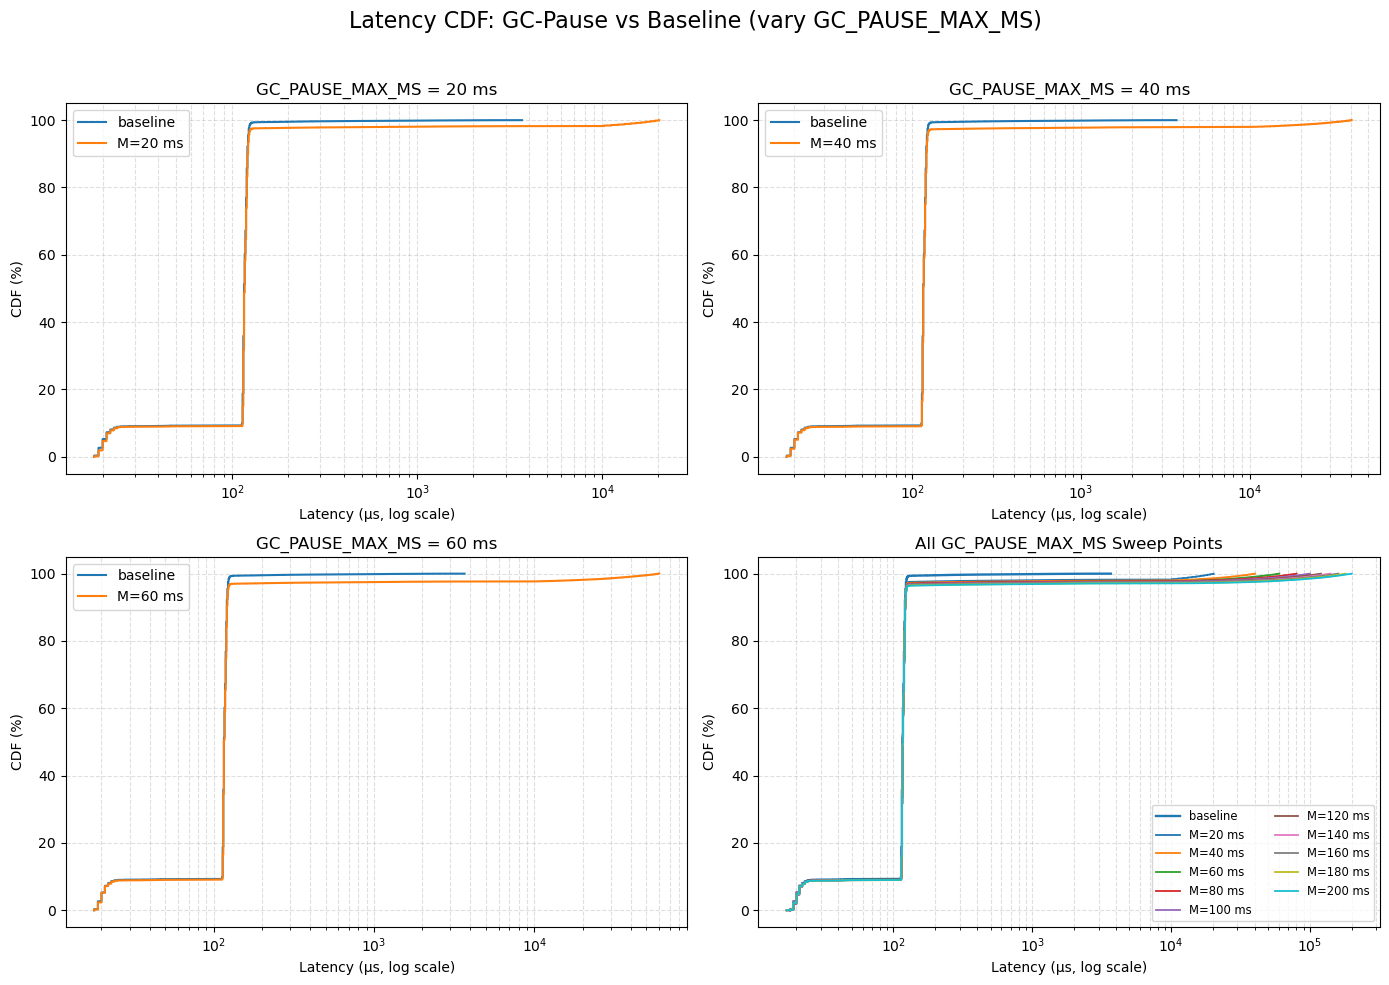

In [65]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
SWEEP_DIR      = r"C:\logs\sweep_logs\gc_pause_sweep_GC_PAUSE_MAX_MS"
BASELINE_FILE  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP    = None   # e.g. 1e6 to clip extreme outliers

# These are the *fixed* GC-pause parameters you used when generating the sweep:
CONST_GC_INTERVAL_MS   = 1000   # average interval between GC pauses
CONST_GC_JITTER_MS     = 100    # ± jitter on that interval
CONST_GC_PAUSE_MIN_MS  = 10     # minimum pause duration
# ────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    """Read the 2nd comma-delimited field (latency) from each CSV line."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2: 
                continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                lats.append(v)
    return np.array(lats)

# 1) Discover all sweep logs & extract GC_PAUSE_MAX_MS from filenames
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"GC_PAUSE_MAX_MS(\d+)\.log$", fn)
    if not m or not fn.endswith(".log"):
        continue
    max_ms = int(m.group(1))
    configs.append((max_ms, fn, f"M={max_ms} ms"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No logs found in {SWEEP_DIR}")

# 2) Print parameter tables
print("#### GC-Pause-Max Sweep Constants")
print("| Parameter               | Value  |")
print("|:------------------------|:------:|")
print(f"| GC_INTERVAL_MS (ms)     | {CONST_GC_INTERVAL_MS}  |")
print(f"| GC_JITTER_MS (±ms)      | {CONST_GC_JITTER_MS}   |")
print(f"| GC_PAUSE_MIN_MS (ms)    | {CONST_GC_PAUSE_MIN_MS}   |")
print()
print("#### Swept GC_PAUSE_MAX_MS Values")
print("| GC_PAUSE_MAX_MS (ms) |")
print("|:--------------------:|")
for max_ms, _, _ in configs:
    print(f"|         {max_ms}         |")
print()

# 3) Load & sort baseline latencies
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError(f"Baseline appears empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) Prepare a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# 5) Plot first three sweep points individually
for idx, (max_ms, fn, label) in enumerate(configs[:3]):
    ax = axes[idx]
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base, base_cdf, lw=1.5, label="baseline", color='tab:blue')
        ax.plot(data, cdf,      lw=1.5, label=label,      color='tab:orange')
    else:
        ax.text(0.5, 0.5, "no data", ha='center', va='center')
    ax.set_xscale('log')
    ax.set_ylabel("CDF (%)")
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_title(f"GC_PAUSE_MAX_MS = {max_ms} ms")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 6) Overlay all sweep points in the bottom-right
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for max_ms, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data):
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_ylabel("CDF (%)")
ax.set_xlabel("Latency (µs, log scale)")
ax.set_title("All GC_PAUSE_MAX_MS Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small', ncol=2)

plt.suptitle("Latency CDF: GC-Pause vs Baseline (vary GC_PAUSE_MAX_MS)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### Media-Retries Sweep Constants
| Parameter                    | Value |
|:-----------------------------|:-----:|
| MAX_MEDIA_RETRIES            |   2   |
| MEDIA_RETRY_DELAY_MS (ms)    |  100   |

#### Swept INJECT_PCT Values
| INJECT_PCT (%) |
|:---------------:|
|      5       |
|      10       |
|      15       |
|      20       |
|      25       |
|      30       |



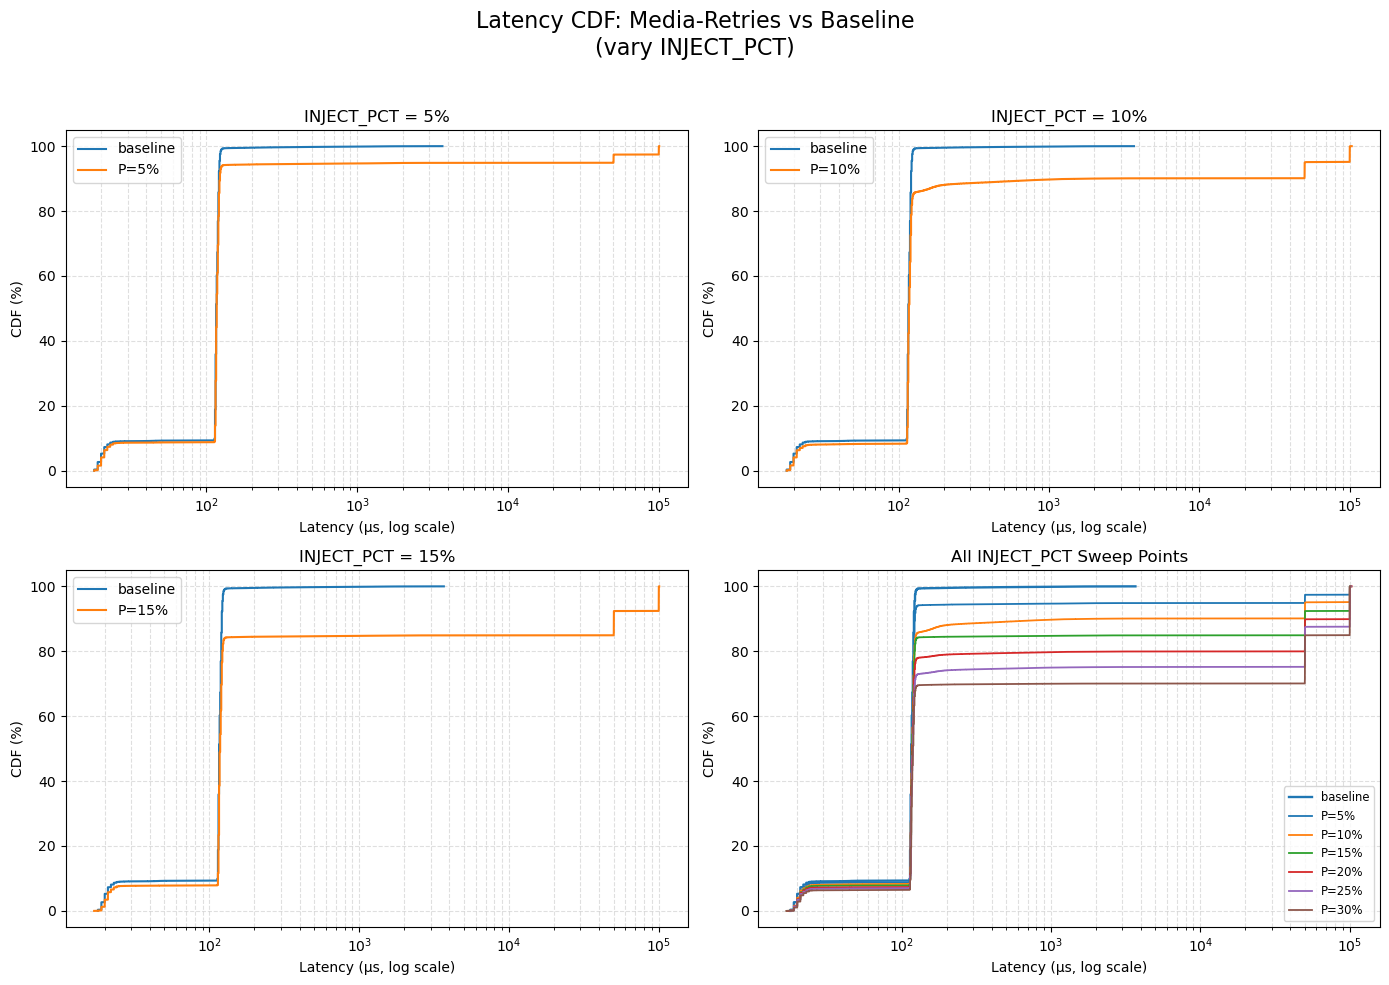

In [67]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
SWEEP_DIR      = r"C:\logs\sweep_logs\media_retries_sweep_INJECT_PCT"
BASELINE_FILE  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP    = None   # or e.g. 1e6 to clip outliers

# These are the *fixed* parameters you held constant in that sweep:
CONST_MAX_MEDIA_RETRIES     = 2     # number of extra retries per failing I/O
CONST_MEDIA_RETRY_DELAY_MS  = 100   # per-retry delay in milliseconds
# ────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    """Read the 2nd comma-delimited field (latency in µs) from each CSV line."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2: continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                lats.append(v)
    return np.array(lats)

# 1) Discover all sweep logs & extract INJECT_PCT from filenames
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"INJECT_PCT(\d+)\.log$", fn)
    if not m: 
        continue
    pct = int(m.group(1))
    configs.append((pct, fn, f"P={pct}%"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No logs found in {SWEEP_DIR}")

# 2) Print out the parameter tables
print("#### Media-Retries Sweep Constants")
print("| Parameter                    | Value |")
print("|:-----------------------------|:-----:|")
print(f"| MAX_MEDIA_RETRIES            |   {CONST_MAX_MEDIA_RETRIES}   |")
print(f"| MEDIA_RETRY_DELAY_MS (ms)    |  {CONST_MEDIA_RETRY_DELAY_MS}   |")
print()
print("#### Swept INJECT_PCT Values")
print("| INJECT_PCT (%) |")
print("|:---------------:|")
for pct, _, _ in configs:
    print(f"|      {pct}       |")
print()

# 3) Load & sort baseline latencies
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError(f"Baseline appears empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) Prepare a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# 5) Plot first three injection-pct points individually
for idx, (pct, fn, label) in enumerate(configs[:3]):
    ax = axes[idx]
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base,    base_cdf, lw=1.5, label="baseline", color='tab:blue')
        ax.plot(data,    cdf,      lw=1.5, label=label,      color='tab:orange')
    else:
        ax.text(0.5,0.5,"no data",ha='center',va='center')
    ax.set_xscale('log')
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_ylabel("CDF (%)")
    ax.set_title(f"INJECT_PCT = {pct}%")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 6) Overlay all sweep points in bottom-right
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for pct, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data):
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_xlabel("Latency (µs, log scale)")
ax.set_ylabel("CDF (%)")
ax.set_title("All INJECT_PCT Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: Media-Retries vs Baseline\n(vary INJECT_PCT)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### Media-Retries Sweep Constants
| Parameter                    | Value |
|:-----------------------------|:-----:|
| INJECT_PCT (%)               |  20   |
| MEDIA_RETRY_DELAY_MS (ms)    |  100   |

#### Swept MAX_MEDIA_RETRIES Values
| MAX_MEDIA_RETRIES |
|:-----------------:|
|        1         |
|        2         |
|        3         |
|        4         |
|        5         |



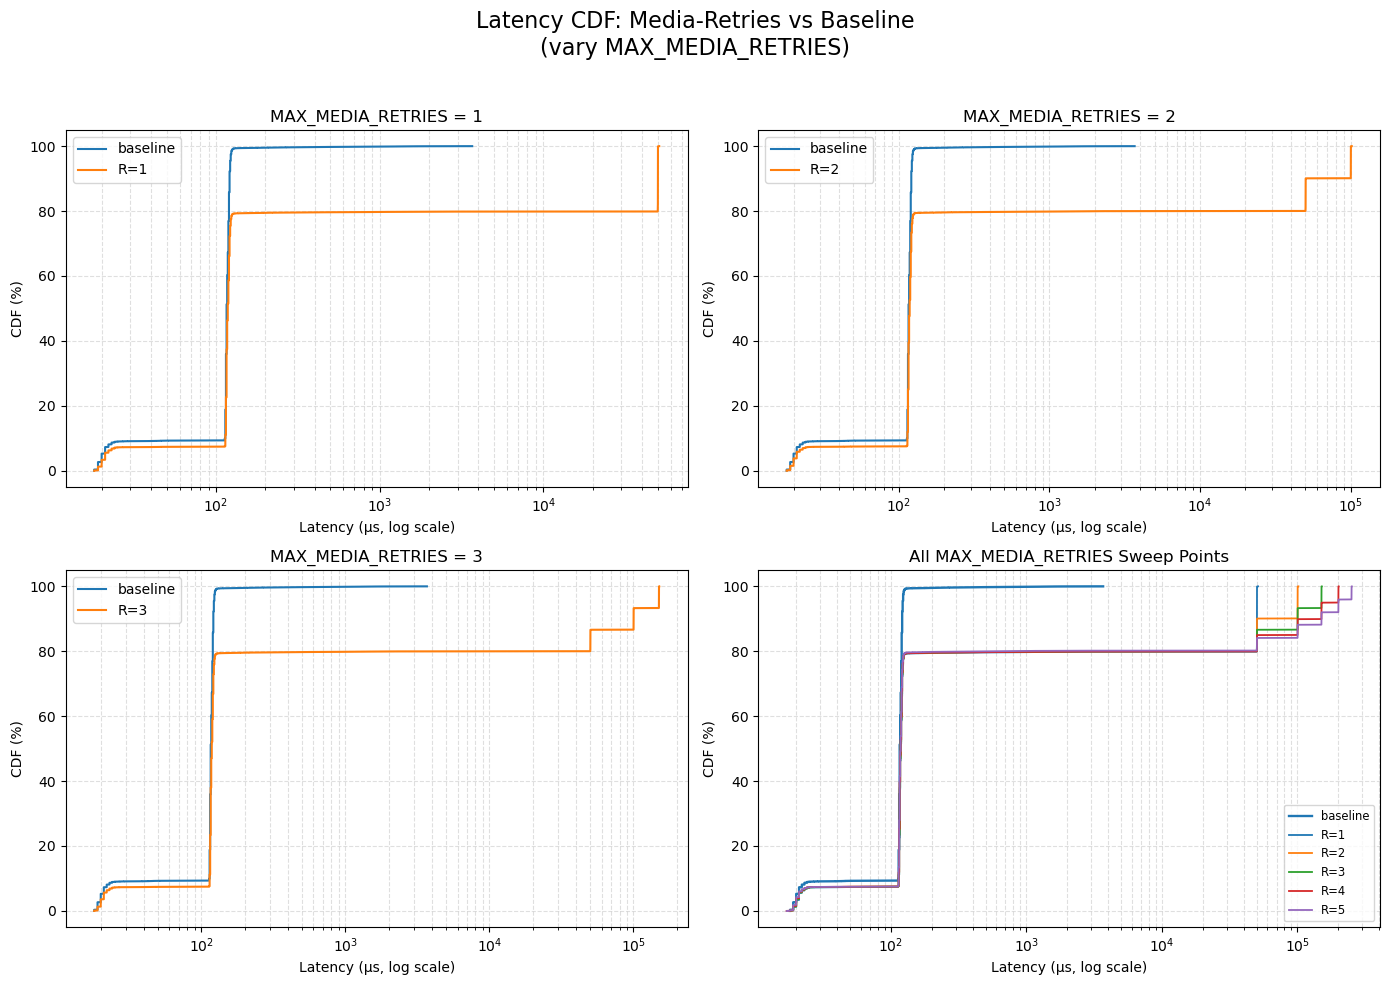

In [69]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
SWEEP_DIR      = r"C:\logs\sweep_logs\media_retries_sweep_MAX_MEDIA_RETRIES"
BASELINE_FILE  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP    = None   # or e.g. 1e6 to clip outliers

# These are the *fixed* values you held constant in that experiment:
CONST_INJECT_PCT           = 20     # % chance of injecting the media-retry fault
CONST_MEDIA_RETRY_DELAY_MS = 100    # per-retry delay in milliseconds
# ────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    """Read the 2nd comma-delimited field (latency in µs) from each CSV line."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2: 
                continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                lats.append(v)
    return np.array(lats)

# 1) discover all sweep logs and extract retry-count from filenames
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"_MAX_MEDIA_RETRIES(\d+)\.log$", fn)
    if not m:
        continue
    retries = int(m.group(1))
    configs.append((retries, fn, f"R={retries}"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No logs found in {SWEEP_DIR}")

# 2) print out the two Markdown tables
print("#### Media-Retries Sweep Constants")
print("| Parameter                    | Value |")
print("|:-----------------------------|:-----:|")
print(f"| INJECT_PCT (%)               |  {CONST_INJECT_PCT}   |")
print(f"| MEDIA_RETRY_DELAY_MS (ms)    |  {CONST_MEDIA_RETRY_DELAY_MS}   |")
print()
print("#### Swept MAX_MEDIA_RETRIES Values")
print("| MAX_MEDIA_RETRIES |")
print("|:-----------------:|")
for retries, _, _ in configs:
    print(f"|        {retries}         |")
print()

# 3) load & sort baseline latencies
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError(f"Baseline appears empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) prepare a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# 5) plot first three retry counts individually
for idx, (retries, fn, label) in enumerate(configs[:3]):
    ax = axes[idx]
    path = os.path.join(SWEEP_DIR, fn)
    data = load_latencies(path, LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base,   base_cdf, lw=1.5, label="baseline", color='tab:blue')
        ax.plot(data,   cdf,      lw=1.5, label=label,      color='tab:orange')
    else:
        ax.text(0.5,0.5,"no data",ha='center',va='center')
    ax.set_xscale('log')
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_ylabel("CDF (%)")
    ax.set_title(f"MAX_MEDIA_RETRIES = {retries}")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 6) overlay all retry-counts in bottom-right
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for retries, fn, label in configs:
    path = os.path.join(SWEEP_DIR, fn)
    data = load_latencies(path, LATENCY_CAP)
    if not len(data):
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_xlabel("Latency (µs, log scale)")
ax.set_ylabel("CDF (%)")
ax.set_title("All MAX_MEDIA_RETRIES Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: Media-Retries vs Baseline\n(vary MAX_MEDIA_RETRIES)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### MLC-Variability Sweep Constants
| Parameter               | Value |
|:------------------------|:-----:|
| SLOW_PAGE_RATE (%)      |   10   |

#### Swept MLC_SLOW_FACTOR Values
| MLC_SLOW_FACTOR (×) |
|:-------------------:|
|         5         |
|         6         |
|         7         |
|         8         |
|         9         |
|         10         |
|         11         |
|         12         |



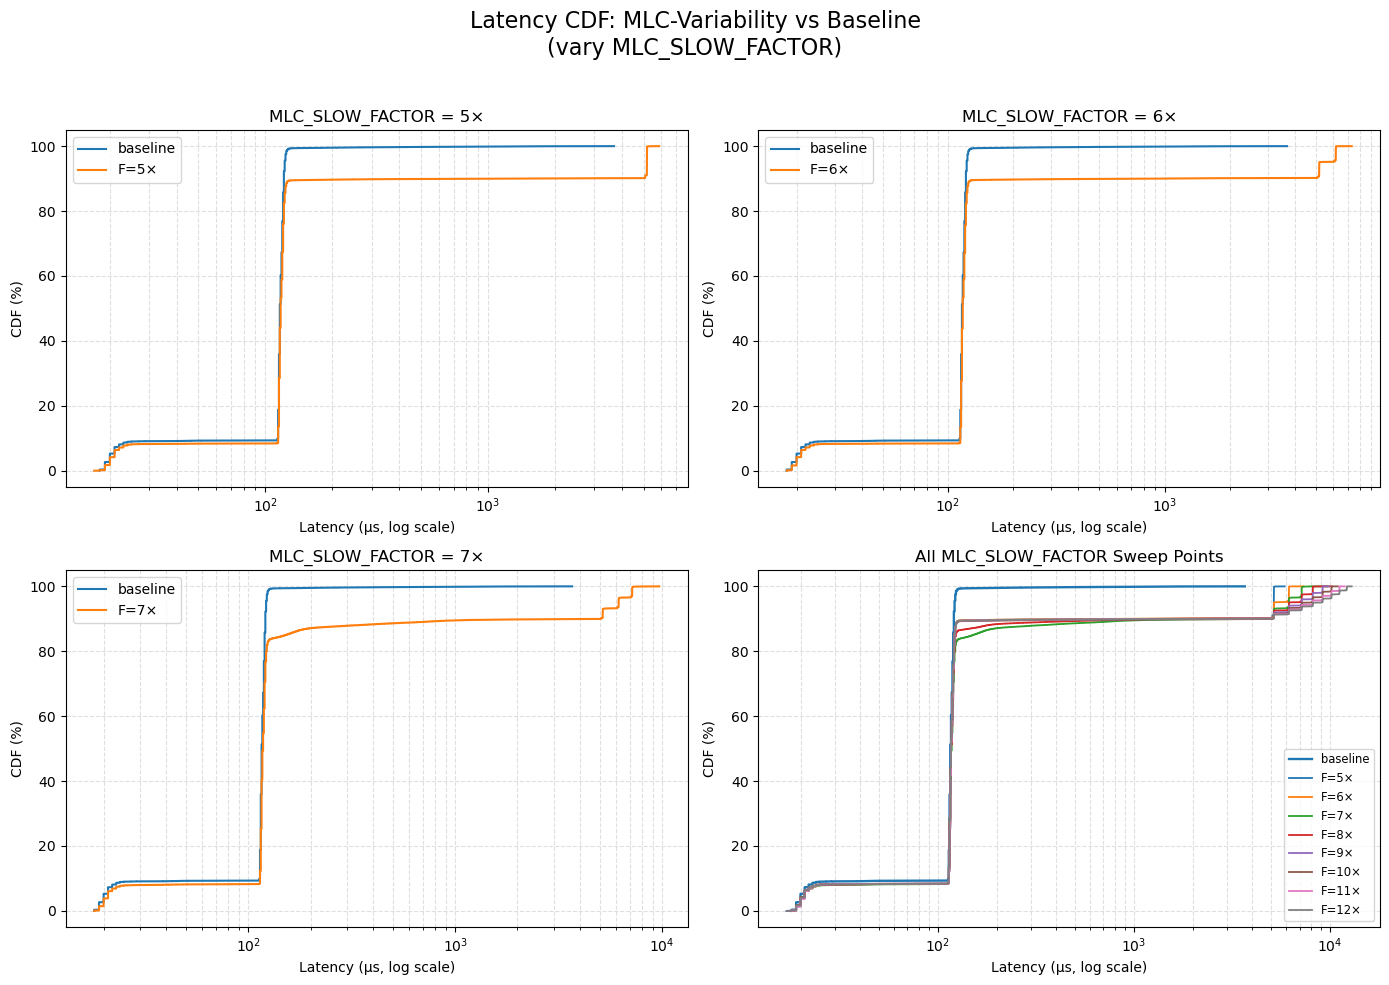

In [71]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
SWEEP_DIR      = r"C:\logs\sweep_logs\mlc_variability_sweep_MLC_SLOW_FACTOR"
BASELINE_FILE  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP    = None   # or e.g. 1e6 to clip outliers

# the one constant you held fixed while sweeping:
CONST_SLOW_PAGE_RATE = 10   # % of pages treated as "slow"
# ────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    """Read the 2nd comma-delimited field (latency in µs) from each CSV line."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2: 
                continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                lats.append(v)
    return np.array(lats)

# 1) discover all sweep logs and extract the MLC_SLOW_FACTOR from filenames
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"_MLC_SLOW_FACTOR(\d+)\.log$", fn)
    if not m:
        continue
    factor = int(m.group(1))
    configs.append((factor, fn, f"F={factor}×"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No sweep logs found in {SWEEP_DIR}")

# 2) print out the two Markdown tables
print("#### MLC-Variability Sweep Constants")
print("| Parameter               | Value |")
print("|:------------------------|:-----:|")
print(f"| SLOW_PAGE_RATE (%)      |   {CONST_SLOW_PAGE_RATE}   |")
print()
print("#### Swept MLC_SLOW_FACTOR Values")
print("| MLC_SLOW_FACTOR (×) |")
print("|:-------------------:|")
for factor, _, _ in configs:
    print(f"|         {factor}         |")
print()

# 3) load & sort baseline latencies
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError(f"Baseline appears empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) prepare a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# 5) plot first three factors individually
for idx, (factor, fn, label) in enumerate(configs[:3]):
    ax = axes[idx]
    path = os.path.join(SWEEP_DIR, fn)
    data = load_latencies(path, LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base,   base_cdf, lw=1.5, label="baseline", color='tab:blue')
        ax.plot(data,   cdf,      lw=1.5, label=label,      color='tab:orange')
    else:
        ax.text(0.5,0.5,"no data",ha='center',va='center')
    ax.set_xscale('log')
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_ylabel("CDF (%)")
    ax.set_title(f"MLC_SLOW_FACTOR = {factor}×")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 6) overlay all factors in bottom-right
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for factor, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data):
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_xlabel("Latency (µs, log scale)")
ax.set_ylabel("CDF (%)")
ax.set_title("All MLC_SLOW_FACTOR Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: MLC-Variability vs Baseline\n(vary MLC_SLOW_FACTOR)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### MLC-Variability Sweep Constants
| Parameter                | Value |
|:-------------------------|:-----:|
| MLC_SLOW_FACTOR (×)      |   8   |

#### Swept SLOW_PAGE_RATE Values
| SLOW_PAGE_RATE (%) |
|:------------------:|
|         5         |
|         10         |
|         15         |
|         20         |
|         25         |



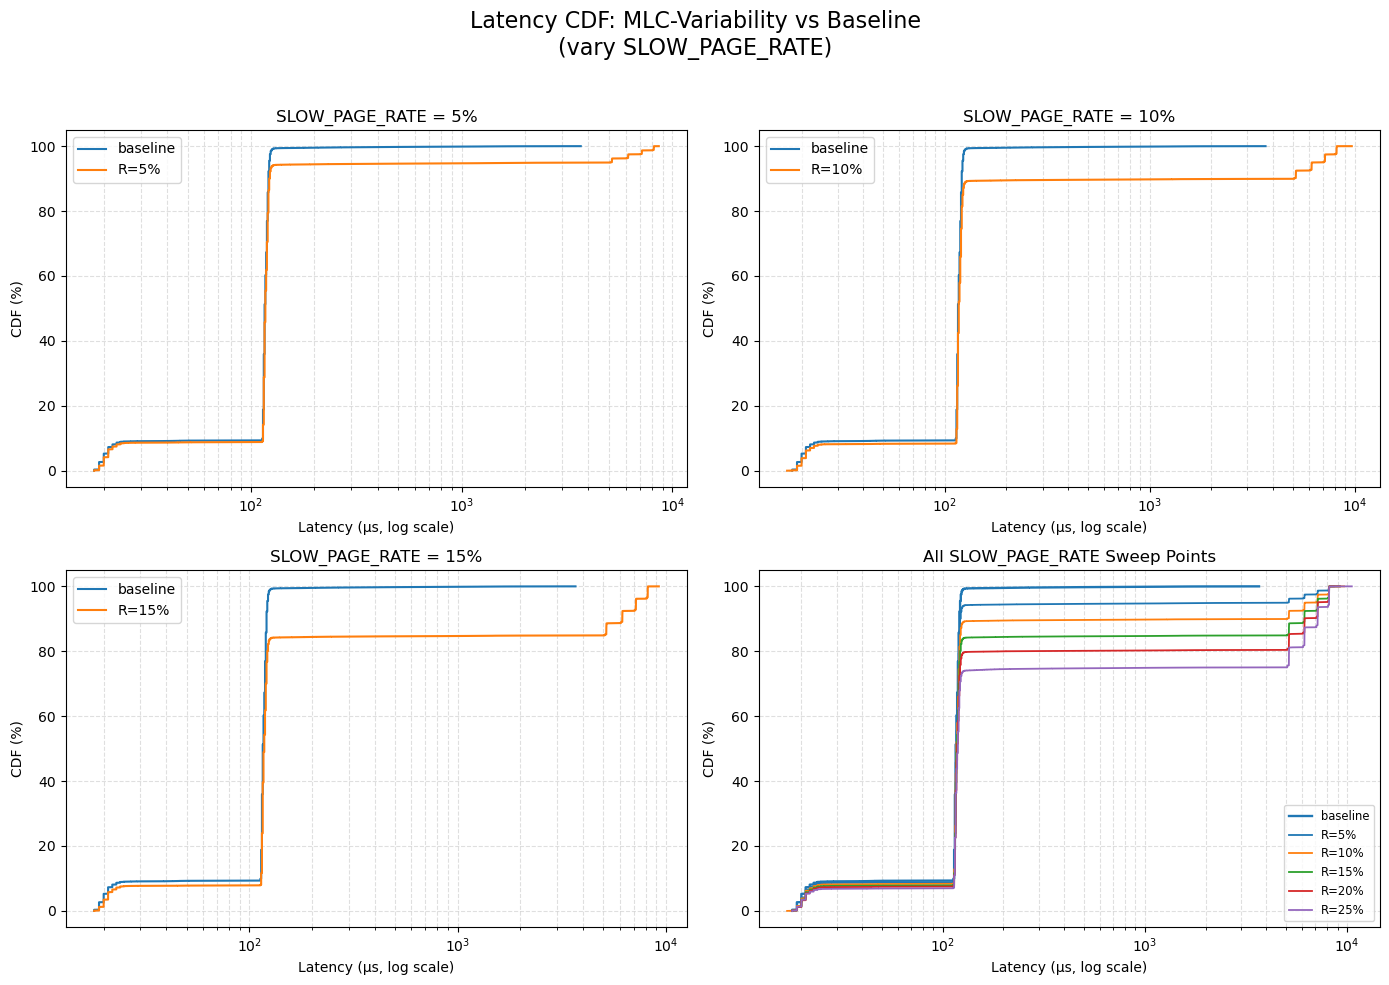

In [73]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
SWEEP_DIR      = r"C:\logs\sweep_logs\mlc_variability_sweep_SLOW_PAGE_RATE"
BASELINE_FILE  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP    = None   # or e.g. 1e6 to clip outliers

# the one constant held fixed during this sweep:
CONST_MLC_SLOW_FACTOR = 8   # × slower on slow pages
# ────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    """Read 2nd comma‐delimited field (latency µs) from each CSV line."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2:
                continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                lats.append(v)
    return np.array(lats)

# 1) discover all sweep logs and extract the SLOW_PAGE_RATE from filenames
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"_SLOW_PAGE_RATE(\d+)\.log$", fn)
    if not m:
        continue
    rate = int(m.group(1))
    configs.append((rate, fn, f"R={rate}%"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No sweep logs found in {SWEEP_DIR}")

# 2) print two Markdown tables
print("#### MLC-Variability Sweep Constants")
print("| Parameter                | Value |")
print("|:-------------------------|:-----:|")
print(f"| MLC_SLOW_FACTOR (×)      |   {CONST_MLC_SLOW_FACTOR}   |")
print()
print("#### Swept SLOW_PAGE_RATE Values")
print("| SLOW_PAGE_RATE (%) |")
print("|:------------------:|")
for rate, _, _ in configs:
    print(f"|         {rate}         |")
print()

# 3) load & sort baseline latencies
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError(f"Baseline appears empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) prepare a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# 5) plot first three sweep points individually
for idx, (rate, fn, label) in enumerate(configs[:3]):
    ax = axes[idx]
    path = os.path.join(SWEEP_DIR, fn)
    data = load_latencies(path, LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base,  base_cdf, lw=1.5, label="baseline", color='tab:blue')
        ax.plot(data,  cdf,      lw=1.5, label=label,      color='tab:orange')
    else:
        ax.text(0.5,0.5,"no data",ha='center',va='center')
    ax.set_xscale('log')
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_ylabel("CDF (%)")
    ax.set_title(f"SLOW_PAGE_RATE = {rate}%")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 6) overlay all rates in bottom-right
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for rate, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data):
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_xlabel("Latency (µs, log scale)")
ax.set_ylabel("CDF (%)")
ax.set_title("All SLOW_PAGE_RATE Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: MLC-Variability vs Baseline\n(vary SLOW_PAGE_RATE)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### Voltage-Read-Retry Sweep Constants
| Parameter              | Value  |
|:-----------------------|:------:|
| RETRY_COUNT            |   5    |
| MIN_DELAY_US (µs)      |  100   |
| MAX_DELAY_US (µs)      |  10000  |

#### Swept INJECT_PCT Values
| INJECT_PCT (%) |
|:--------------:|
|      5        |
|      10       |
|      15       |
|      20       |
|      25       |
|      30       |
|      35       |
|      40       |
|      45       |
|      50       |



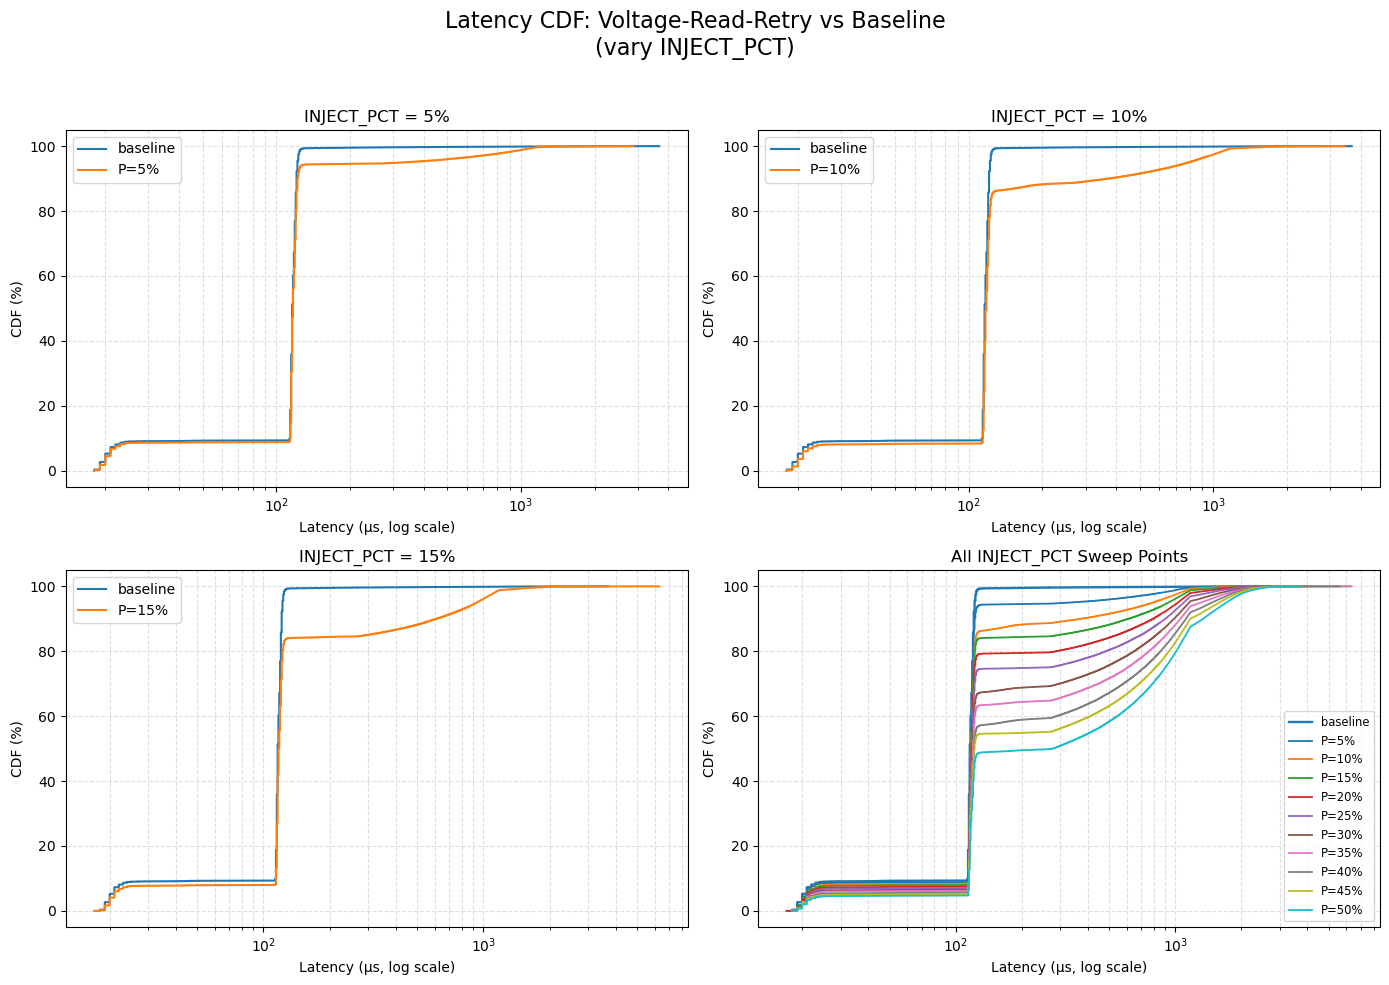

In [75]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
SWEEP_DIR      = r"C:\logs\sweep_logs\voltage_read_retry_sweep_INJECT_PCT"
BASELINE_FILE  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP    = None   # e.g. 1e6 to clip extreme outliers

# Fixed constants for this sweep:
CONST_RETRY_COUNT   = 5       # max retries per error event
CONST_MIN_DELAY_US  = 100     # min per-retry delay (µs)
CONST_MAX_DELAY_US  = 10000   # max per-retry delay (µs)
# ────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    """Read 2nd comma-delimited field (latency µs) from each CSV line."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2: 
                continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                lats.append(v)
    return np.array(lats)

# 1) discover all sweep logs and extract INJECT_PCT from filenames
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"_INJECT_PCT(\d+)\.log$", fn)
    if not m:
        continue
    pct = int(m.group(1))
    configs.append((pct, fn, f"P={pct}%"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No sweep logs found in {SWEEP_DIR}")

# 2) print Markdown tables of constants + swept values
print("#### Voltage-Read-Retry Sweep Constants")
print("| Parameter              | Value  |")
print("|:-----------------------|:------:|")
print(f"| RETRY_COUNT            |   {CONST_RETRY_COUNT}    |")
print(f"| MIN_DELAY_US (µs)      |  {CONST_MIN_DELAY_US}   |")
print(f"| MAX_DELAY_US (µs)      |  {CONST_MAX_DELAY_US}  |")
print()
print("#### Swept INJECT_PCT Values")
print("| INJECT_PCT (%) |")
print("|:--------------:|")
for pct, _, _ in configs:
    print(f"|      {pct:<3}      |")
print()

# 3) load & sort baseline latencies
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError(f"Baseline appears empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) prepare a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# 5) plot first three injection‐rates individually
for idx, (pct, fn, label) in enumerate(configs[:3]):
    ax = axes[idx]
    path = os.path.join(SWEEP_DIR, fn)
    data = load_latencies(path, LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base,  base_cdf, lw=1.5, label="baseline", color='tab:blue')
        ax.plot(data,  cdf,      lw=1.5, label=label,      color='tab:orange')
    else:
        ax.text(0.5, 0.5, "no data", ha='center', va='center')
    ax.set_xscale('log')
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_ylabel("CDF (%)")
    ax.set_title(f"INJECT_PCT = {pct}%")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 6) overlay all injection‐rates in bottom-right
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for pct, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data):
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_xlabel("Latency (µs, log scale)")
ax.set_ylabel("CDF (%)")
ax.set_title("All INJECT_PCT Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: Voltage-Read-Retry vs Baseline\n(vary INJECT_PCT)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### Voltage-Read-Retry Sweep Constants
| Parameter               | Value  |
|:------------------------|:------:|
| INJECT_PCT (%)          |  10    |
| MIN_DELAY_US (µs)       |  100  |
| MAX_DELAY_US (µs)       |  1000 |

#### Swept RETRY_COUNT Values
| RETRY_COUNT |
|:-----------:|
|     1       |
|     2       |
|     3       |
|     4       |
|     5       |



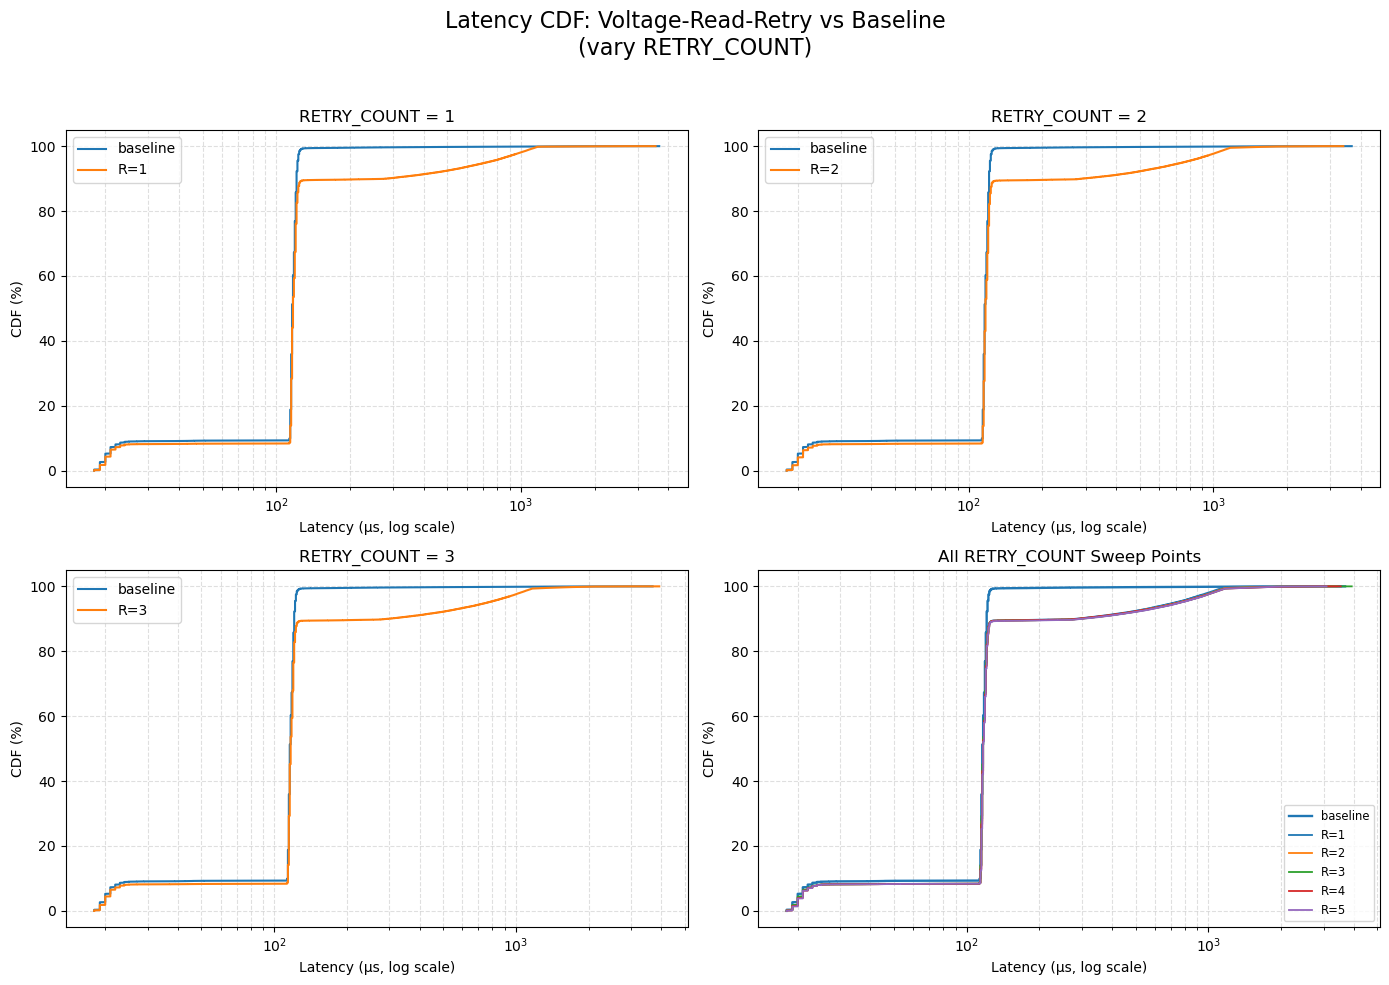

In [81]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
SWEEP_DIR      = r"C:\logs\sweep_logs\voltage_read_retry_sweep_RETRY_COUNT"
BASELINE_FILE  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP    = None   # e.g. 1e6 to clip extreme outliers

# Fixed constants for this sweep:
CONST_INJECT_PCT    = 10     # % chance per I/O to trigger retries
CONST_MIN_DELAY_US  = 100     # µs delay on each retry
CONST_MAX_DELAY_US  = 1000    # µs delay on each retry
# ────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    """Read the 2nd comma-delimited field (latency µs) from each CSV line."""
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2:
                continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                lats.append(v)
    return np.array(lats)

# 1) discover all sweep logs and extract RETRY_COUNT from filenames
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"_RETRY_COUNT(\d+)\.log$", fn)
    if not m:
        continue
    rc = int(m.group(1))
    configs.append((rc, fn, f"R={rc}"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No sweep logs found in {SWEEP_DIR}")

# 2) print Markdown tables of constants + swept values
print("#### Voltage-Read-Retry Sweep Constants")
print("| Parameter               | Value  |")
print("|:------------------------|:------:|")
print(f"| INJECT_PCT (%)          |  {CONST_INJECT_PCT:<3}   |")
print(f"| MIN_DELAY_US (µs)       |  {CONST_MIN_DELAY_US:<4} |")
print(f"| MAX_DELAY_US (µs)       |  {CONST_MAX_DELAY_US:<4} |")
print()
print("#### Swept RETRY_COUNT Values")
print("| RETRY_COUNT |")
print("|:-----------:|")
for rc, _, _ in configs:
    print(f"|     {rc:<3}     |")
print()

# 3) load & sort baseline latencies
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError(f"Baseline appears empty: {BASELINE_FILE}")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) prepare a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

# 5) plot first three retry-counts individually
for idx, (rc, fn, label) in enumerate(configs[:3]):
    ax = axes[idx]
    path = os.path.join(SWEEP_DIR, fn)
    data = load_latencies(path, LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base, base_cdf, lw=1.5, label="baseline", color='tab:blue')
        ax.plot(data, cdf,      lw=1.5, label=label,      color='tab:orange')
    else:
        ax.text(0.5, 0.5, "no data", ha='center', va='center')
    ax.set_xscale('log')
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_ylabel("CDF (%)")
    ax.set_title(f"RETRY_COUNT = {rc}")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 6) overlay all retry-counts in bottom-right
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for rc, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data):
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_xlabel("Latency (µs, log scale)")
ax.set_ylabel("CDF (%)")
ax.set_title("All RETRY_COUNT Sweep Points")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: Voltage-Read-Retry vs Baseline\n(vary RETRY_COUNT)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### Wear-Pathology Sweep Constants
| Parameter                 | Value |
|:--------------------------|:-----:|
| WEAR_PCT (%)              |  30   |
| WEAR_MIN_US (µs)          | 500   |
| WEAR_MAX_US (µs)          | 1000  |
| TOTAL_CHANNELS (NCHANNELS)|  1    |

#### Swept MAX_HOT_CHANNELS Values
| MAX_HOT_CHANNELS |
|:----------------:|
|       1         |
|       2         |
|       3         |
|       4         |
|       5         |
|       6         |
|       7         |
|       8         |



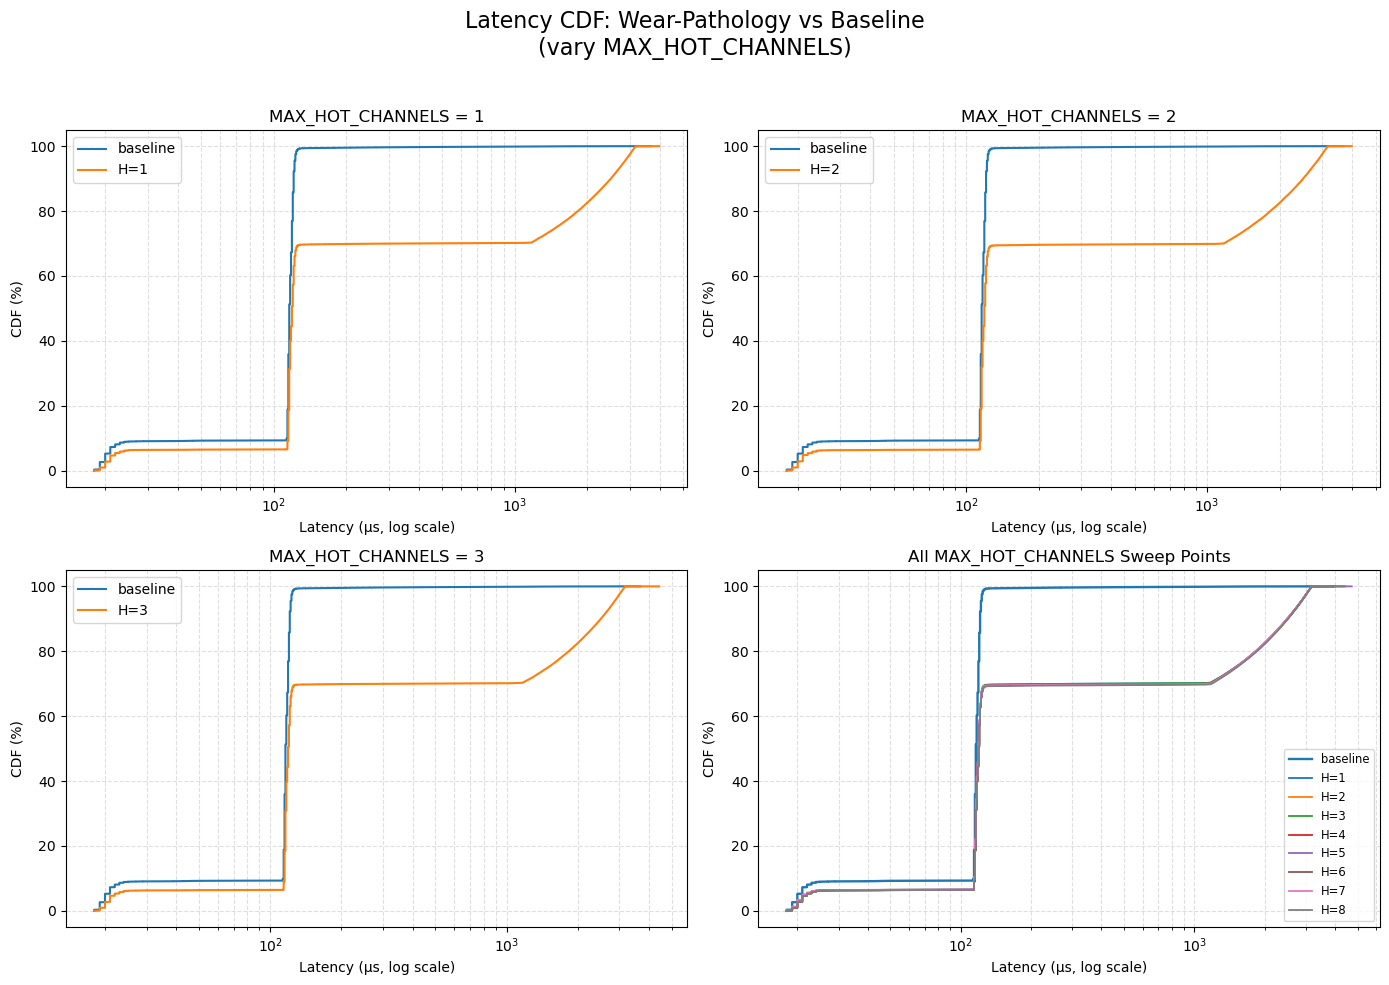

In [89]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG: adjust these to match exactly what you passed to configure_fault.sh ────
SWEEP_DIR      = r"C:\logs\sweep_logs\wear_pathology_sweep_MAX_HOT_CHANNELS"
BASELINE_FILE  = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP    = None   # or e.g. 1e6 to clip extreme outliers

# These were held constant during the sweep:
CONST_WEAR_PCT     = 30      # “Hot‐channel injection rate (%)”
CONST_MIN_US       = 500     # “Min per-I/O delay on hot channel (µs)”
CONST_MAX_US       = 1000    # “Max per-I/O delay on hot channel (µs)”
CONST_TOTAL_CH     = 1       # “Total number of SSD channels (NCHANNELS)”
# ────────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    lats = []
    with open(path,'r') as f:
        for L in f:
            parts = L.strip().split(',')
            if len(parts) < 2: continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                lats.append(v)
    return np.array(lats)

# 1) discover all the sweep logs and parse out the MAX_HOT_CHANNELS value
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"_MAX_HOT_CHANNELS(\d+)\.log$", fn)
    if not m: continue
    k = int(m.group(1))
    configs.append((k, fn, f"H={k}"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No sweep logs found in {SWEEP_DIR}")

# 2) print Markdown tables
print("#### Wear-Pathology Sweep Constants")
print("| Parameter                 | Value |")
print("|:--------------------------|:-----:|")
print(f"| WEAR_PCT (%)              |  {CONST_WEAR_PCT:<3}  |")
print(f"| WEAR_MIN_US (µs)          | {CONST_MIN_US:<5} |")
print(f"| WEAR_MAX_US (µs)          | {CONST_MAX_US:<5} |")
print(f"| TOTAL_CHANNELS (NCHANNELS)|  {CONST_TOTAL_CH:<3}  |")
print()
print("#### Swept MAX_HOT_CHANNELS Values")
print("| MAX_HOT_CHANNELS |")
print("|:----------------:|")
for k,_,_ in configs:
    print(f"|       {k:<3}       |")
print()

# 3) load & sort baseline
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base)==0:
    raise RuntimeError("Baseline log appears empty!")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) prepare 2×2 grid
fig, axes = plt.subplots(2,2,figsize=(14,10))
axes = axes.flatten()

# 5) plot the first three channel‐counts individually
for i, (k, fn, label) in enumerate(configs[:3]):
    ax = axes[i]
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base, base_cdf, lw=1.5, label="baseline", color='tab:blue')
        ax.plot(data, cdf,       lw=1.5, label=label,      color='tab:orange')
    else:
        ax.text(0.5,0.5,"no data",ha='center',va='center')
    ax.set_xscale('log')
    ax.set_title(f"MAX_HOT_CHANNELS = {k}")
    ax.set_xlabel("Latency (µs, log scale)")
    ax.set_ylabel("CDF (%)")
    ax.grid(True,which='both',ls='--',alpha=0.4)
    ax.legend()

# 6) overlay *all* on the bottom-right panel
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for k, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data): continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_title("All MAX_HOT_CHANNELS Sweep Points")
ax.set_xlabel("Latency (µs, log scale)")
ax.set_ylabel("CDF (%)")
ax.grid(True,which='both',ls='--',alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: Wear-Pathology vs Baseline\n(vary MAX_HOT_CHANNELS)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


#### Wear-Pathology Sweep Constants
| Parameter                 | Value |
|:--------------------------|:-----:|
| WEAR_PCT (%)              |  20  |
| MAX_HOT_CHANNELS          |  5   |
| WEAR_MAX_US (µs)          | 1000 |
| TOTAL_CHANNELS (NCHANNELS)|  1   |

#### Swept WEAR_MIN_US Values (µs)
| WEAR_MIN_US |
|:-----------:|
|    500  |
|    1000 |
|    1500 |
|    2000 |



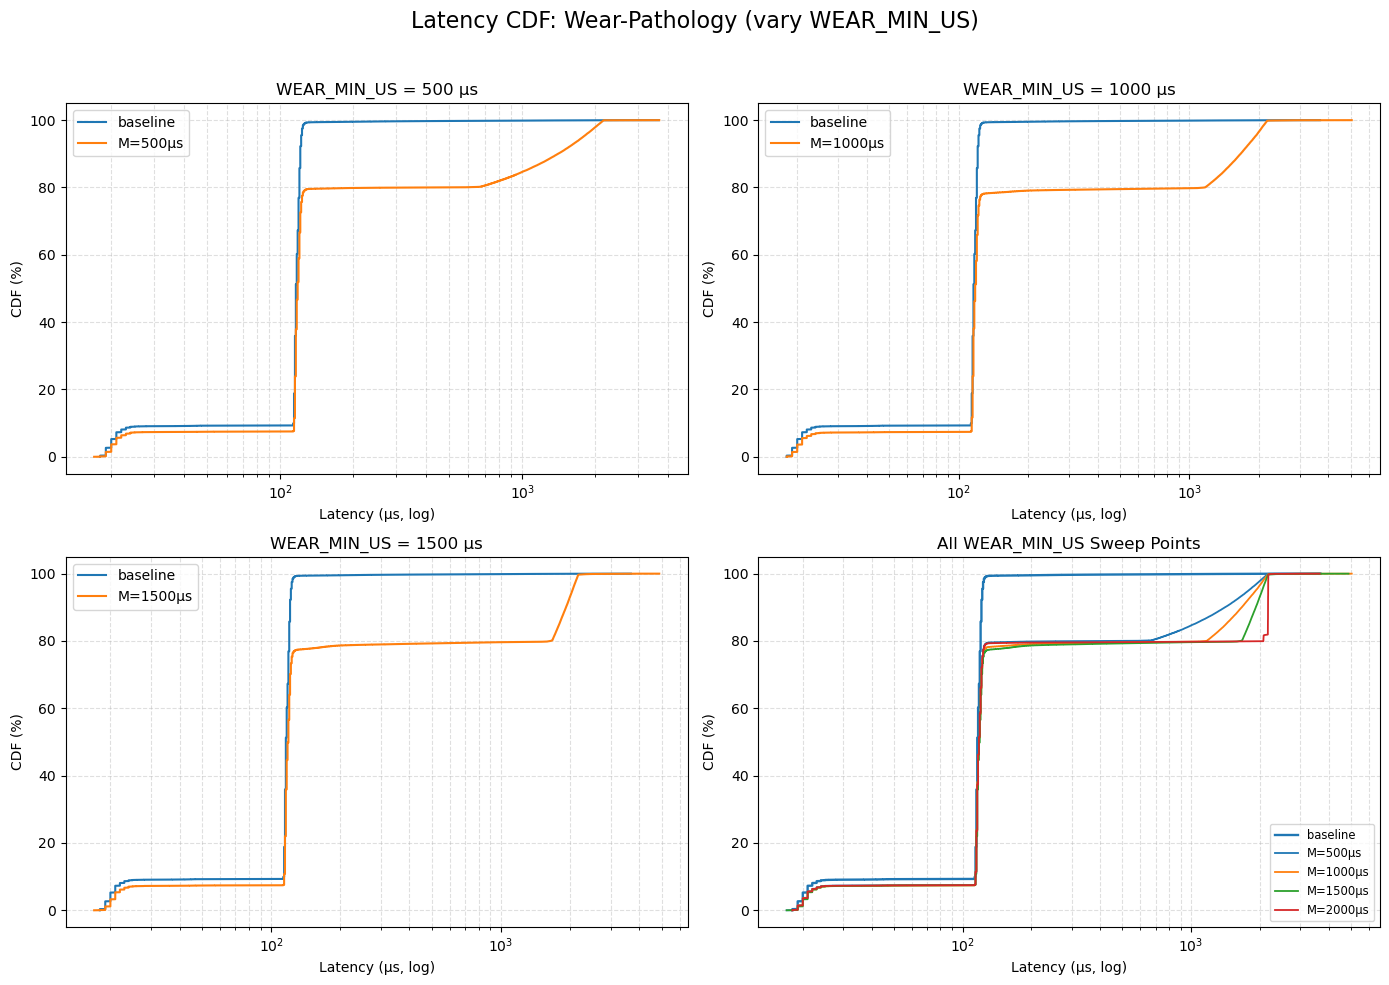

In [87]:
#!/usr/bin/env python3
import os, re
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIGURATION — adjust these to match your sweep ─────────────────────────
SWEEP_DIR     = r"C:\logs\sweep_logs\wear_pathology_sweep_WEAR_MIN_US"
BASELINE_FILE = r"C:\logs\logs\trace_p100_sample100k_baseline.log"
LATENCY_CAP   = None   # e.g. 1e6 to clip outliers

# These were held constant while sweeping WEAR_MIN_US:
CONST_WEAR_PCT       = 20      # Hot-channel injection rate (%)
CONST_MAX_HOT_CH     = 5       # Number of hot channels congested
CONST_WEAR_MAX_US    = 1000    # Max per-I/O delay on hot channel (µs)
CONST_TOTAL_CHANNELS = 1       # NCHANNELS
# ─────────────────────────────────────────────────────────────────────────────

def load_latencies(path, cap=None):
    lats = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 2: 
                continue
            try:
                v = float(parts[1])
            except:
                continue
            if cap is None or v <= cap:
                lats.append(v)
    return np.array(lats)

# 1) Discover all sweep logs & extract their WEAR_MIN_US values
files = sorted(os.listdir(SWEEP_DIR))
configs = []
for fn in files:
    m = re.search(r"_WEAR_MIN_US(\d+)\.log$", fn)
    if not m:
        continue
    ms = int(m.group(1))
    configs.append((ms, fn, f"M={ms}µs"))
configs.sort(key=lambda x: x[0])
if not configs:
    raise RuntimeError(f"No logs found in {SWEEP_DIR}")

# 2) Print Markdown tables
print("#### Wear-Pathology Sweep Constants")
print("| Parameter                 | Value |")
print("|:--------------------------|:-----:|")
print(f"| WEAR_PCT (%)              |  {CONST_WEAR_PCT:<3} |")
print(f"| MAX_HOT_CHANNELS          |  {CONST_MAX_HOT_CH:<3} |")
print(f"| WEAR_MAX_US (µs)          | {CONST_WEAR_MAX_US:<4} |")
print(f"| TOTAL_CHANNELS (NCHANNELS)|  {CONST_TOTAL_CHANNELS:<3} |")
print()
print("#### Swept WEAR_MIN_US Values (µs)")
print("| WEAR_MIN_US |")
print("|:-----------:|")
for ms,_,_ in configs:
    print(f"|    {ms:<4} |")
print()

# 3) Load & sort baseline
base = load_latencies(BASELINE_FILE, LATENCY_CAP)
if len(base) == 0:
    raise RuntimeError("Baseline log appears empty!")
base.sort()
base_cdf = np.arange(1, len(base)+1) / len(base) * 100

# 4) Prepare 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 5) Plot first three sweep points individually
for i, (ms, fn, label) in enumerate(configs[:3]):
    ax = axes[i]
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if len(data):
        data.sort()
        cdf = np.arange(1, len(data)+1) / len(data) * 100
        ax.plot(base,  base_cdf, lw=1.5, label="baseline", color='tab:blue')
        ax.plot(data,  cdf,      lw=1.5, label=label,      color='tab:orange')
    else:
        ax.text(0.5, 0.5, "no data", ha='center', va='center')
    ax.set_xscale('log')
    ax.set_title(f"WEAR_MIN_US = {ms} µs")
    ax.set_xlabel("Latency (µs, log)")
    ax.set_ylabel("CDF (%)")
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()

# 6) Overlay all sweep points in bottom-right
ax = axes[3]
ax.plot(base, base_cdf, lw=1.7, label="baseline", color='tab:blue')
for ms, fn, label in configs:
    data = load_latencies(os.path.join(SWEEP_DIR, fn), LATENCY_CAP)
    if not len(data):
        continue
    data.sort()
    cdf = np.arange(1, len(data)+1) / len(data) * 100
    ax.plot(data, cdf, lw=1.3, label=label)
ax.set_xscale('log')
ax.set_title("All WEAR_MIN_US Sweep Points")
ax.set_xlabel("Latency (µs, log)")
ax.set_ylabel("CDF (%)")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend(loc='lower right', fontsize='small')

plt.suptitle("Latency CDF: Wear-Pathology (vary WEAR_MIN_US)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()
